In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/ThiCK/Allurez/Bai nop")

In [3]:
%cd /content/drive/MyDrive/ThiCK/Allurez/Bai nop

/content


In [4]:
final_result = []

# ***1,000 samples data***

## **Import Libraries**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

pd.options.mode.chained_assignment = None

##**Load Data for 1,000 samples data**

In [6]:
path = 'data_'
small_data = pd.read_csv("data_small_clean.csv")

In [7]:
small_data.head()

,Shape,Carat,Color,Clarity,Cut,Fluorescence,Polish,Symmetry,Length,Width,Depth,Log_Price
0,1,1.01,4,6,0,0,0,0,6.43,6.47,3.95,9.513182
1,1,1.40,0,4,0,1,0,0,7.13,7.16,4.46,10.208248
2,1,1.85,7,5,0,0,0,0,8.20,8.26,5.02,10.206920
3,1,0.30,5,7,0,1,0,0,4.31,4.34,2.61,6.075346
4,1,0.56,3,4,0,0,0,0,5.23,5.27,3.26,8.031060


##**Prepare data for model building**

### Split data to train/ validation/ test by 60/20/20 using ***Stratified Sampling***

In [8]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, f_regression, RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import time

<Axes: >

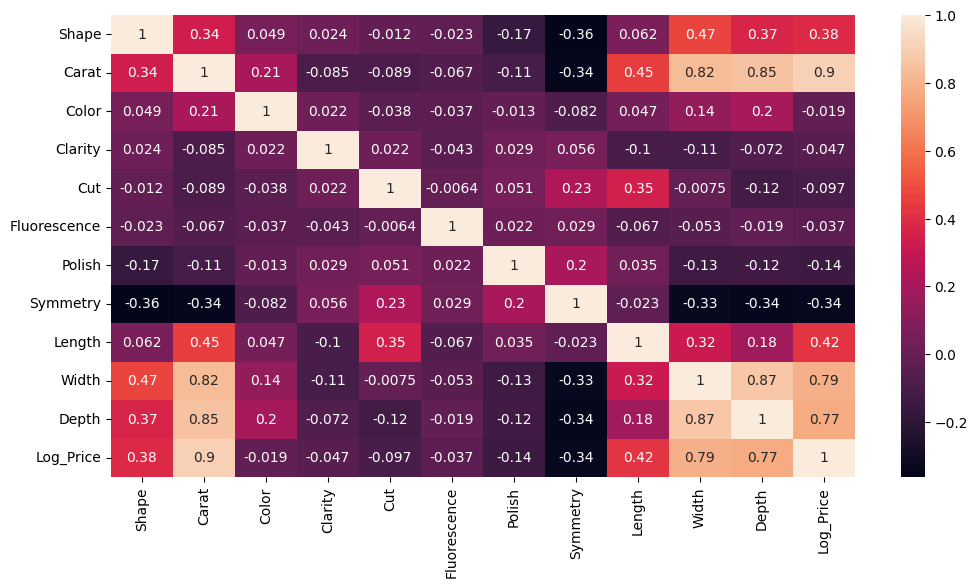

In [9]:
df_diamond = small_data.copy()
correlation_matrix = df_diamond.corr()
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True)

Từ heatmap ở trên, ta có thể nhận xét như sau:
- ***Length, Width, Depth*** có tương quan khá mạnh với giá (***Log_Price***)
- ***Carat*** có tương quan mạnh nhất đối với giá (***Log_Price***) - 0.9
- ***Polish, Symmetry*** có tương quan yếu nhất
- Từ đây ta có thể thấy ***Carat*** tương quan tốt nhất với giá. Ta sẽ dùng feature này cho ***Stratified Sampling***




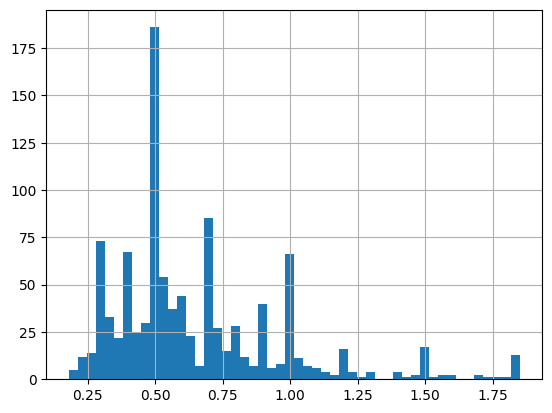

In [10]:
df_diamond["Carat"].hist(bins = 50)
plt.show()

Ta thấy phần lớn rơi vào khoảng từ 0.25 đến 1.25 carat. Ta có thể chia chúng làm 5 loại, những viên có carat lớn hơn loại 5 thì xếp vào loại 5.

In [11]:
# Divide diamond carats by 0.3 to limit the number of each carat categories
df_diamond['Carat_Category'] = np.ceil(df_diamond['Carat']/0.3)

# Merge categories > 5 in 5
df_diamond["Carat_Category"].where(df_diamond["Carat_Category"] < 5, 5.0, inplace = True)

In [12]:
df_diamond["Carat_Category"].value_counts()

2.0    512
3.0    246
4.0    132
1.0     77
5.0     61
Name: Carat_Category, dtype: int64

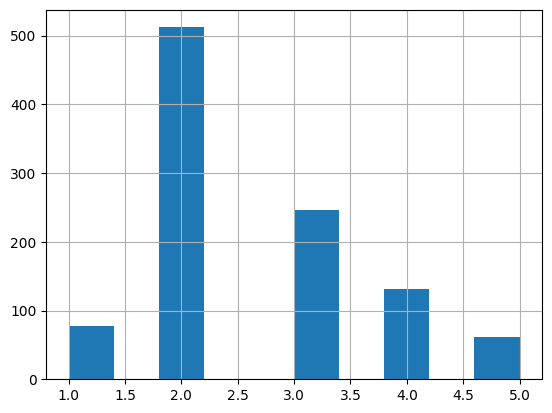

In [13]:
df_diamond["Carat_Category"].hist()
plt.show()

Phân bố các nhóm carat khá ổn sau khi được chia thành 5 loại
- Bây giờ, ta sẽ chia data bằng **Stratified Sampling** dựa trên carat categories (Function StratifiedShuffleSplit of Scikit-Learn's)
- Ta sẽ chia data thành 3 phần ***60/20/20*** tương ứng với ***Train/Validation/Test***

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# Run the split. Creates one split and shares 20% of the dataset for the test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Separate the stratified train set and the test set
for train_index, test_index in split.split(df_diamond, df_diamond["Carat_Category"]):
  stratified_train_set = df_diamond.iloc[train_index]
  stratified_test_set = df_diamond.iloc[test_index]

# Perform another split on the train set to create a train/validation set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

# Separate the stratified train set and the validation set
for train_index, val_index in split.split(stratified_train_set, stratified_train_set["Carat_Category"]):
  stratified_val_set = stratified_train_set.iloc[val_index]
  stratified_train_set = stratified_train_set.iloc[train_index]

print(f"Train data size: {len(stratified_train_set)}")
print(f"Validation data size: {len(stratified_val_set)}")
print(f"Test data size: {len(stratified_test_set)}")

Train data size: 616
Validation data size: 206
Test data size: 206


In [15]:
# Train set
X_train = stratified_train_set.drop(['Log_Price', 'Carat_Category'], axis=1)
y_train = stratified_train_set['Log_Price']
# Validation set
X_val = stratified_val_set.drop(['Log_Price', 'Carat_Category'], axis=1)
y_val = stratified_val_set['Log_Price']
# Test set
X_test = stratified_test_set.drop(['Log_Price', 'Carat_Category'], axis=1)
y_test = stratified_test_set['Log_Price']

### Categorical and Numerical features

In [16]:
numeric_cols = ['Carat',
                'Length',
                'Width',
                'Depth']
object_cols = [col for col in X_train.columns if col not in numeric_cols]
print("Categorical variables:", object_cols)
print("Numeric variables:", numeric_cols)

Categorical variables: ['Shape', 'Color', 'Clarity', 'Cut', 'Fluorescence', 'Polish', 'Symmetry']
Numeric variables: ['Carat', 'Length', 'Width', 'Depth']


In [17]:
scaler = MinMaxScaler()
X_train_copy = X_train.copy()
X_train_copy[numeric_cols] = scaler.fit_transform(X_train_copy[numeric_cols])

X_val_copy = X_val.copy()
X_val_copy[numeric_cols] = scaler.transform(X_val_copy[numeric_cols])

X_test_copy = X_test.copy()
X_test_copy[numeric_cols] = scaler.transform(X_test_copy[numeric_cols])

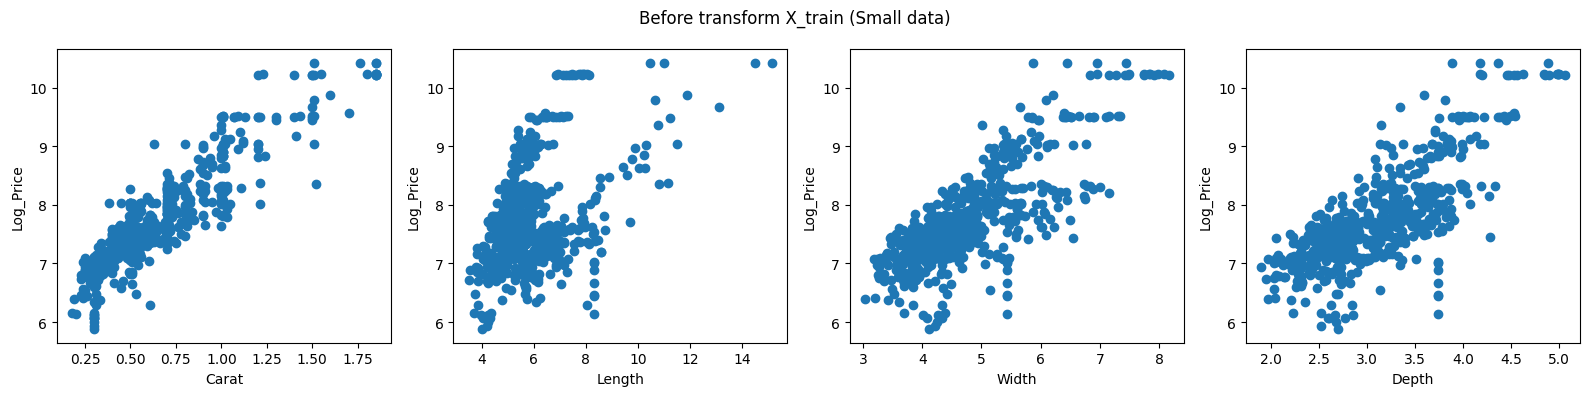

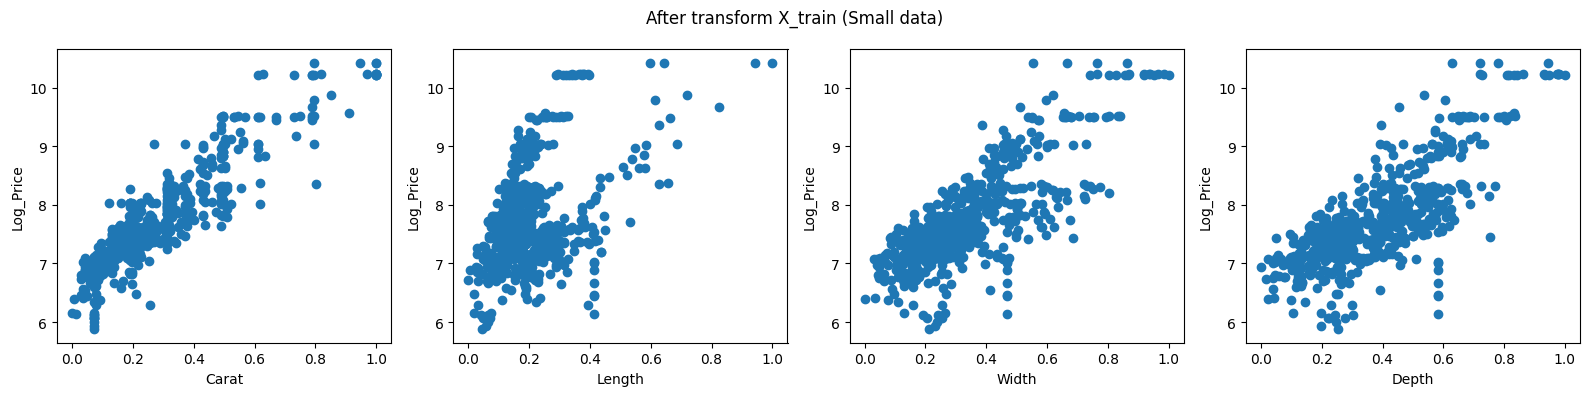

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, column in enumerate(numeric_cols):
    axs[i].scatter(X_train[column], y_train, label=column)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Log_Price')

fig.suptitle('Before transform X_train (Small data)')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, column in enumerate(numeric_cols):
    axs[i].scatter(X_train_copy[column], y_train, label=column)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Log_Price')

fig.suptitle('After transform X_train (Small data)')
plt.tight_layout()
plt.show()

##**Model Building**
- Linear Regression
- Random Forest Regression


--- Training & Validating on Linear Regression model | MinMaxScaler---
- Time of fitting Linear Regression model: 0.04 (s)
  + RMSE on training: 0.30051670128262487
  + R2 on training: 0.8650069878283403
------------ Testing Linear Regression model | MinMaxScaler-----------
-> RMSE on testing: 0.29343077723259886
-> R2 on testing: 0.8809653361986646

--- Training & Validating on Random Forest Regression model | MinMaxScaler---
- Time of fitting Random Forest Regression model: 0.309 (s)
  + RMSE on training: 0.2169290113495003
  + R2 on training: 0.9296588707779418
------------ Testing Random Forest Regression model | MinMaxScaler-----------
-> RMSE on testing: 0.22646342282058876
-> R2 on testing: 0.929098037562513

--- Training & Validating on Linear Regression model | StandardScaler---
- Time of fitting Linear Regression model: 0.004 (s)
  + RMSE on training: 0.30051670128262487
  + R2 on training: 0.8650069878283403
------------ Testing Linear Regression model | StandardScaler------

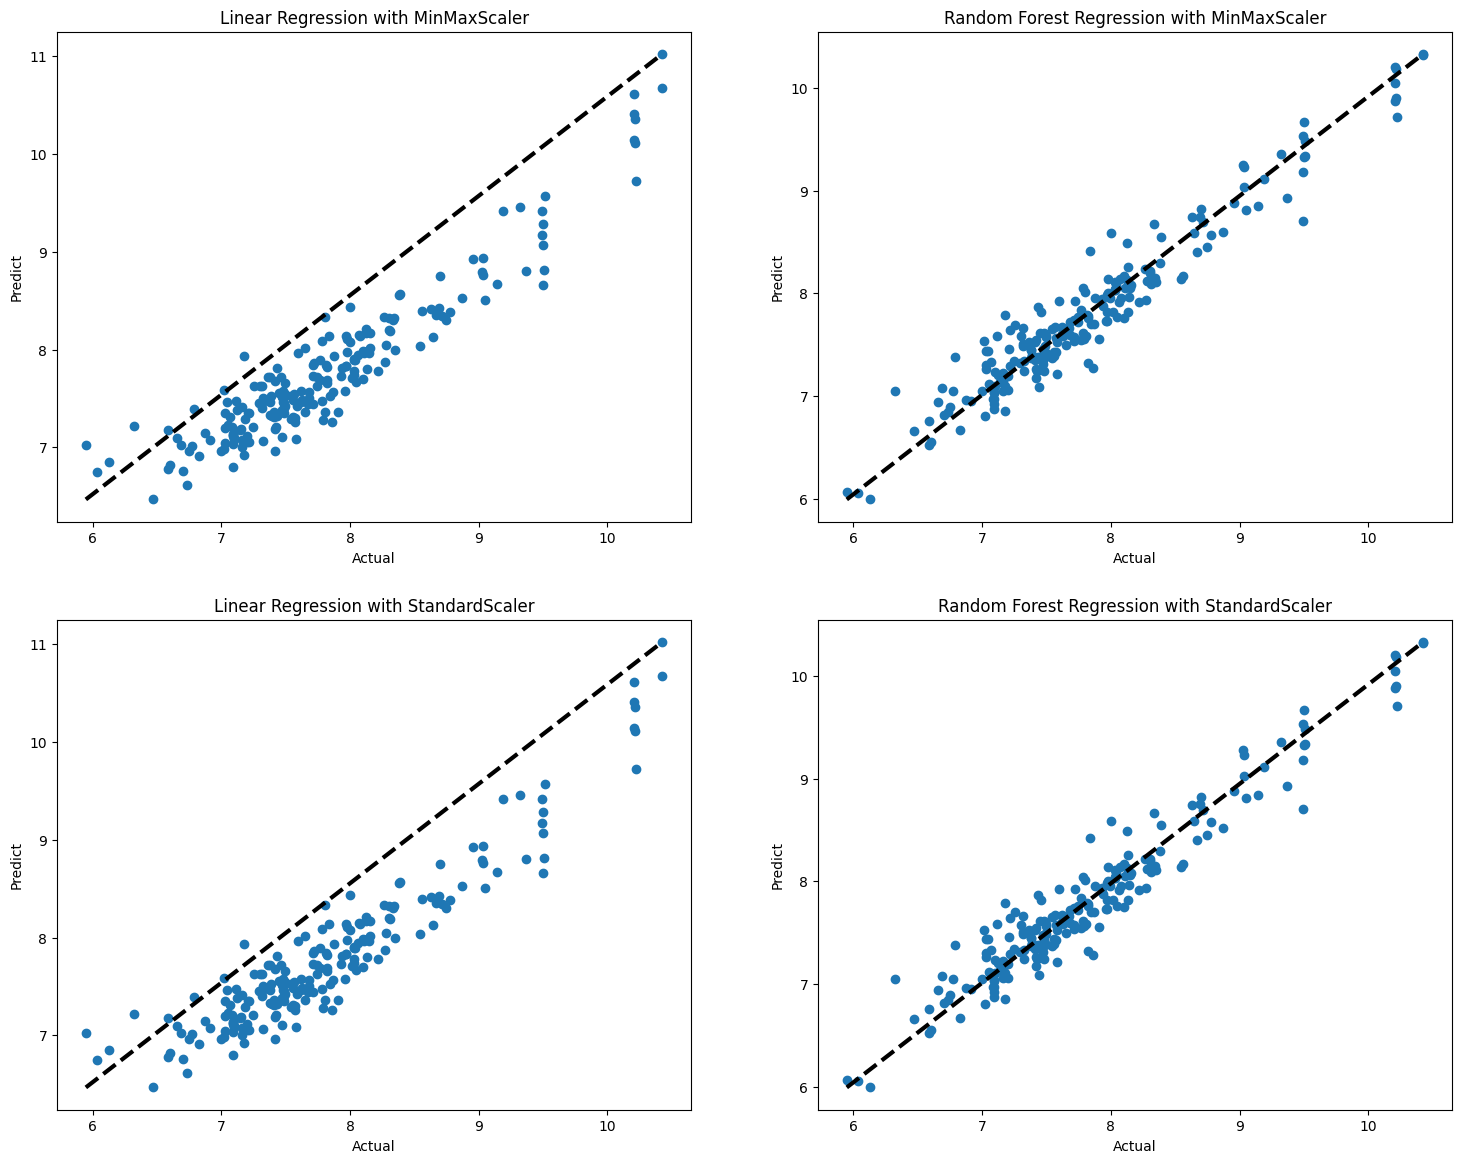

In [ ]:
scaler_list = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

regressor_list = {
  'Linear Regression': LinearRegression(),
  'Random Forest Regression': RandomForestRegressor(random_state=42)
}

regression_name = []
result_r2_compare = []

figure, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
i = 0

for scaler_name, scaler in scaler_list.items():
  j = 0
  res_r2_scaler = []
  for reg_name, regressor in regressor_list.items():
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()
    X_test_copy = X_test.copy()
    X_train_copy[numeric_cols] = scaler.fit_transform(X_train_copy[numeric_cols])
    X_val_copy[numeric_cols] = scaler.transform(X_val_copy[numeric_cols])
    X_test_copy[numeric_cols] = scaler.transform(X_test_copy[numeric_cols])

    regression_name.append(reg_name)
    # Define the pipeline
    pipeline = Pipeline(steps=[(reg_name, regressor)])
    
    # Fit pipeline to train data
    print(f"--- Training & Validating on {reg_name} model | {scaler_name}---")
    start_train = time.time()
    pipeline.fit(X_train_copy, y_train)
    
    y_val_pred = pipeline.predict(X_val_copy)
    rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
    r2_train = r2_score(y_val, y_val_pred)

    end_train = time.time()
    train_time = round(end_train - start_train, 3)
    print(f"- Time of fitting {reg_name} model: {train_time} (s)")
    print(f"  + RMSE on training: {rmse_train}")
    print(f"  + R2 on training: {r2_train}")

    # Predict on the test data
    y_test_pred = pipeline.predict(X_test_copy)
    # Evaluate the performance on the test set
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"------------ Testing {reg_name} model | {scaler_name}-----------")
    print(f"-> RMSE on testing: {rmse_test}")
    print(f"-> R2 on testing: {r2_test}")
    print('='*70,'\n')
    res_r2_scaler.append([reg_name, scaler_name, r2_train, r2_test, train_time])

    # Plot predict result
    axs[i, j].scatter(y_test, y_test_pred)
    axs[i, j].plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'k--', lw=3)

    axs[i, j].set_xlabel('Actual')
    axs[i, j].set_ylabel('Predict')
    axs[i, j].set_title(f'{reg_name} with {scaler_name}')

    j += 1
  i += 1
  result_r2_compare.append(res_r2_scaler)

In [ ]:
result_r2_compare_df = pd.DataFrame(result_r2_compare[0], columns=['Regressor', 'Scaler', 'R2 Training Score', 'R2 Testing Score', 'Training Time'])
result_r2_compare_df.sort_values(by='R2 Testing Score', ascending=False)

,Regressor,Scaler,R2 Training Score,R2 Testing Score,Training Time
1,Random Forest Regression,MinMaxScaler,0.929659,0.929098,0.309
0,Linear Regression,MinMaxScaler,0.865007,0.880965,0.040


In [ ]:
# temp_linear_df = ['1.000', result_r2_compare_df.iloc[0, 0], result_r2_compare_df.iloc[0, 4], result_r2_compare_df.iloc[0, 3] * 100]
# temp_rf_df = ['1.000', f"{result_r2_compare_df.iloc[1, 0]} Base", result_r2_compare_df.iloc[0, 4], result_r2_compare_df.iloc[1, 3] * 100]
# final_result.append(temp_linear_df)
# final_result.append(temp_rf_df)
final_result

[['1.000', 'Linear Regression', 0.04, 88.09653361986646],
 ['1.000', 'Random Forest Regression Base', 0.04, 92.90980375625129]]

[Text(0, 0, 'Linear Regression'), Text(1, 0, 'Random Forest Regression')]

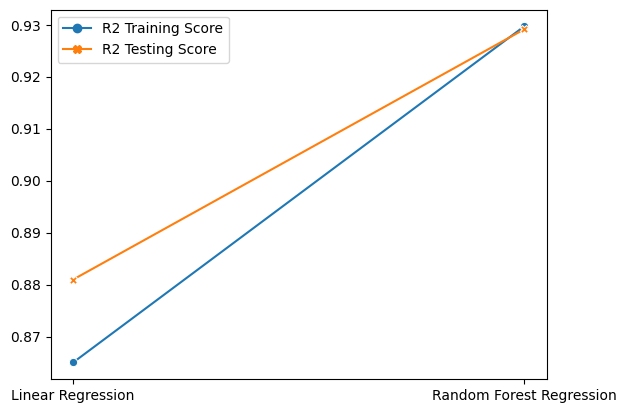

In [ ]:
# Visualize the training and the testing R2 Scores of 2 models
ax = sns.lineplot(data=[result_r2_compare_df['R2 Training Score'], result_r2_compare_df['R2 Testing Score']], dashes=False, markers=True)
ax.set_xticks(range(len(result_r2_compare_df['Regressor'])))
ax.set_xticklabels(result_r2_compare_df['Regressor'])

### **Nhận xét**
Ta sẽ sử dụng 2 metrics là ***RMSE*** và ***R2 Score*** để đánh giá hiệu suất mô hình.
- **Giá trị RMSE càng nhỏ** thì mô hình càng hiệu quả.
- **Giá trị R2 Score càng lớn** thì mô hình càng hiệu quả.

Nhưng ta sẽ sử dụng ***R2 Score*** để đánh giá hiệu quả mô hình vì nó tương tự như ***Accuracy*** để trực quan hơn ***RMSE***.

*   Sắp xếp R2 Score đối với training và validating data như sau:


> 1. RandomForest Regression
> 2. Linear Regression


*   Sắp xếp R2 Score đối với testing data như sau:


> 1. RandomForest Regression
> 2. Linear Regression

Ta có thể thấy rằng việc sử dụng RandomForest Regression (***92.91%***) mang lại hiệu quả tốt hơn Linear Regression (***88.10%***) về mặt Training & Validating và cả mặt Testing.



## **Hyperparameter Tuning Using RandomizedSearchCV and GridSearchCV**


*   Các hyperparameter quan trọng với RandomForest Regressor:


> 1. n_estimators: numbe of trees in the forest
> 2. max_features: maximum number of features considered for splitting a node
> 3. max_depth: depth of trees in the forest





In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf_base_r2_small = max(result_r2_compare_df.sort_values(by='R2 Testing Score', ascending=False)['R2 Testing Score'])

# List of improvement R2 Score using Grid Search with Cross Validation
improved_test_r2_score_small = [rf_base_r2_small]

# List to track the run time of improvement models
run_time_small = []

### First Parameters Grid with RandomizedSearchCV

In [ ]:
random_param_grid_1 = {
  'bootstrap': [True, False],
  'max_depth': [10, 20, 30, 40, 50],
  'max_features': ['auto', 'sqrt'],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [100, 200, 400, 600, 800, 1000]
 }

In [ ]:
scaler = MinMaxScaler()
X_train_tune = X_train.copy()
X_train_tune[numeric_cols] = scaler.fit_transform(X_train_tune[numeric_cols])

X_val_tune = X_val.copy()
X_val_tune[numeric_cols] = scaler.transform(X_val_tune[numeric_cols])

X_test_tune = X_test.copy()
X_test_tune[numeric_cols] = scaler.transform(X_test_tune[numeric_cols])

In [ ]:
# forest_model = RandomForestRegressor(random_state=42)

# # Using RandomizedSearchCV to tune hyperparameters
# rf_random = RandomizedSearchCV(estimator=forest_model, param_distributions=random_param_grid_1, n_iter=30, cv=5, random_state=42, n_jobs=-1)

# # Fit the random search model
# rf_random.fit(X_train_tune, y_train)
# rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

Training & Validating on RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1000, random_state=42) model
- Time of fitting RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1000, random_state=42) model: 1.971 (s)
Testing RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1000, random_state=42) model
-> RMSE on testing: 0.23684374066296215
-> R2 on testing: 0.9224492602317107


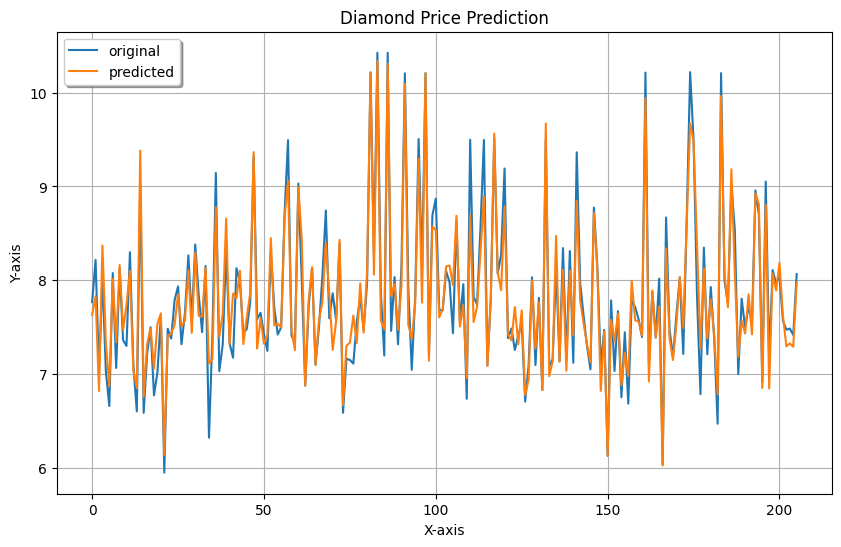

In [ ]:
rf_model = RandomForestRegressor(bootstrap=False, n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(X_train_tune, y_train)

# Validation
y_val_pred = tune_model.predict(X_val_tune)
grid_1_rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
grid_1_r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(X_test_tune)
end_time = time.time()
current_run_time = round(end_time - start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_small.append(current_run_time)

# Evaluate the performance on the test set
grid_1_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
grid_1_r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_small.append(grid_1_r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {grid_1_rmse_test}")
print(f"-> R2 on testing: {grid_1_r2_test}")

# Plot result of prediction after using Grid 1 RandomizedSearchCV
x_ax = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Diamond Price Prediction")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### Second Parameters Grid with RandomizedSearchCV

In [ ]:
random_param_grid_2 = {
  'bootstrap': [True, False],
  'max_depth': [60, 70, 80, 90, 100, None],
  'max_features': ['auto', 'sqrt', 6, 8, 10],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [150, 250, 1200, 1400, 1600, 1800, 2000]
 }

In [ ]:
scaler = MinMaxScaler()
X_train_tune = X_train.copy()
X_train_tune[numeric_cols] = scaler.fit_transform(X_train_tune[numeric_cols])

X_val_tune = X_val.copy()
X_val_tune[numeric_cols] = scaler.transform(X_val_tune[numeric_cols])

X_test_tune = X_test.copy()
X_test_tune[numeric_cols] = scaler.transform(X_test_tune[numeric_cols])

In [ ]:
# forest_model = RandomForestRegressor(random_state=42)

# # Using RandomizedSearchCV to tune hyperparameters
# rf_random = RandomizedSearchCV(estimator=forest_model, param_distributions=random_param_grid_2, n_iter=30, cv=5, random_state=42, n_jobs=-1)

# # Fit the random search model
# rf_random.fit(X_train_tune, y_train)
# rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 6,
 'max_depth': 60,
 'bootstrap': True}

Training & Validating on RandomForestRegressor(max_depth=60, max_features=6, n_estimators=1600,
                      random_state=42) model
- Time of fitting RandomForestRegressor(max_depth=60, max_features=6, n_estimators=1600,
                      random_state=42) model: 4.524 (s)
Testing RandomForestRegressor(max_depth=60, max_features=6, n_estimators=1600,
                      random_state=42) model
-> RMSE on testing: 0.22815541511341728
-> R2 on testing: 0.9280346099576703


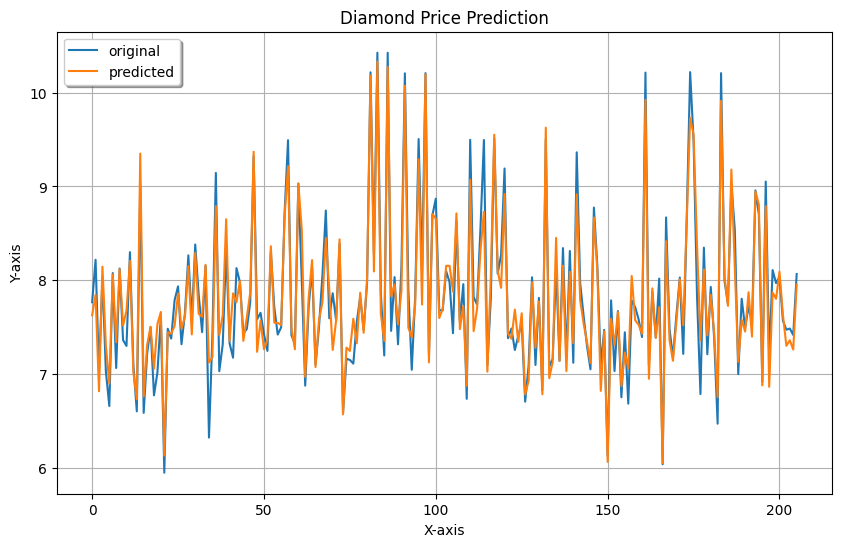

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, n_estimators=1600, min_samples_split=2, min_samples_leaf=1, max_features=6, max_depth=60, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(X_train_tune, y_train)

# Validation
y_val_pred = tune_model.predict(X_val_tune)
grid_2_rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
grid_2_r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(X_test_tune)
end_time = time.time()
current_run_time = round(end_time- start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_small.append(current_run_time)

# Evaluate the performance on the test set
grid_2_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
grid_2_r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_small.append(grid_2_r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {grid_2_rmse_test}")
print(f"-> R2 on testing: {grid_2_r2_test}")

# Plot result of prediction after using Grid 2 RandomizedSearchCV
x_ax = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Diamond Price Prediction")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [ ]:
# Intialize the list using the base and the improved RandomForest Regression models
random_improved_reg_models_small = ['RandomForestRegression', 'RandomForestRegression_RandomSearch_1', 'RandomForestRegression_RandomSearch_2']

# Compare the testing data R2 Score of the base and the improved RandomForest Regression models by using RandomizedSearchCV
random_improved_model_r2_compare_small = pd.DataFrame({'Models' : random_improved_reg_models_small, 'Improved_Testing_R2_Score' : improved_test_r2_score_small})
random_improved_model_r2_compare_small.sort_values(by='Improved_Testing_R2_Score', ascending=False)

,Models,Improved_Testing_R2_Score
0,RandomForestRegression,0.929098
2,RandomForestRegression_RandomSearch_2,0.928035
1,RandomForestRegression_RandomSearch_1,0.922449


In [ ]:
# temp_lr_df = ['1.000', 'Random Forest Regression (RandomizedSearchCV)', run_time_small[-1], random_improved_model_r2_compare_small.iloc[2, 1]*100]
# final_result.append(temp_lr_df)
final_result

[['1.000', 'Linear Regression', 0.04, 88.09653361986646],
 ['1.000', 'Random Forest Regression Base', 0.04, 92.90980375625129],
 ['1,000',
  'Random Forest Regression (RandomizedSearchCV)',
  4.524,
  92.80346099576703]]

[Text(0, 0, 'RandomForestRegression'),
 Text(1, 0, 'RandomForestRegression_RandomSearch_1'),
 Text(2, 0, 'RandomForestRegression_RandomSearch_2')]

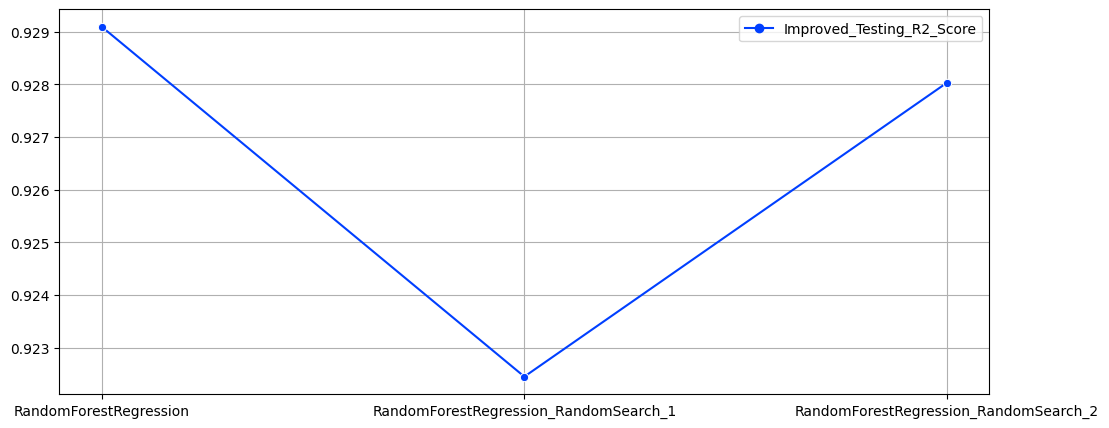

In [ ]:
# Visualize the testing data R2 Scores of the base and the improved RandomForest Regression models by using RandomizedSearchCV
plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-bright')
plt.grid(True)
ax = sns.lineplot(data=[random_improved_model_r2_compare_small['Improved_Testing_R2_Score']], dashes=False, markers=True)
ax.set_xticks(range(len(random_improved_model_r2_compare_small['Models'])))
ax.set_xticklabels(random_improved_model_r2_compare_small['Models'])

### **Nhận xét sự cải thiện hiệu quả mô hình khi sử dụng RandomizedSearchCV**
Sự cải thiện của model thu được từ việc hiệu chỉnh các Hyperparamter của RandomForest Regressor như: n_estimator, bootstrap, max_features, max_depth... được tìm kiếm với ***RandomizedSearchCV*** kết hợp cùng cross-validation (5-folds). Kết quả thu được như sau:
- R2 Score trên test data theo thứ tự giảm dần như sau:

> 1. RandomForest Regression base
> 2. RandomForest Regression using Second Random Search
> 3. RandomForest Regression using First Random Search

- The Base RandomForest Regression model có hiệu quả mô hình cao nhất rơi vào khoảng ***92.91%*** (R2_Score).
- Trong khi đó, RandomForest Regression sử dụng Second Random Search và First Random Search có hiệu quả mô hình lần lượt là ***92.80%*** và ***92.24%***, giảm một chút khoảng ***0.11%*** và ***0.17%*** so với Base RandomForest Regression.

####-> ***Bây giờ ta sẽ sử dụng GridSearchCV để tìm bộ siêu tham số (Hyperparameter) tốt nhất cho mô hình***

### First Parameters Grid with GridSearchCV

In [ ]:
rf_base_r2_small_grid = max(result_r2_compare_df.sort_values(by='R2 Testing Score', ascending=False)['R2 Testing Score'])

# List of improvement R2 Score using Grid Search with Cross Validation
improved_test_r2_score_small_grid = [rf_base_r2_small]

# List to track the run time of improvement models
run_time_small_grid = []

In [ ]:
grid_param_grid_1 = {
  'bootstrap': [True, False],
  'max_depth': [None, 5, 10, 20, 30],
  'max_features': ['auto', 'sqrt'],
  'n_estimators': [75, 100, 125, 150]
}

In [ ]:
scaler = MinMaxScaler()
X_train_tune = X_train.copy()
X_train_tune[numeric_cols] = scaler.fit_transform(X_train_tune[numeric_cols])

X_val_tune = X_val.copy()
X_val_tune[numeric_cols] = scaler.transform(X_val_tune[numeric_cols])

X_test_tune = X_test.copy()
X_test_tune[numeric_cols] = scaler.transform(X_test_tune[numeric_cols])

In [ ]:
# forest_model = RandomForestRegressor(random_state=42)

# # Initialize grid search 1
# grid_search_1 = GridSearchCV(estimator=forest_model, param_grid=grid_param_grid_1, cv=3, scoring='r2', return_train_score=True, n_jobs = -1)

# # Fitting the grid 1 to train data
# grid_search_1.fit(X_train_tune, y_train)
# grid_search_1.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 125}

Training & Validating on RandomForestRegressor(max_depth=20, max_features='auto', n_estimators=125,
                      random_state=42) model


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


- Time of fitting RandomForestRegressor(max_depth=20, max_features='auto', n_estimators=125,
                      random_state=42) model: 0.396 (s)
Testing RandomForestRegressor(max_depth=20, max_features='auto', n_estimators=125,
                      random_state=42) model
-> RMSE on testing: 0.22732385478085423
-> R2 on testing: 0.9285582399353168


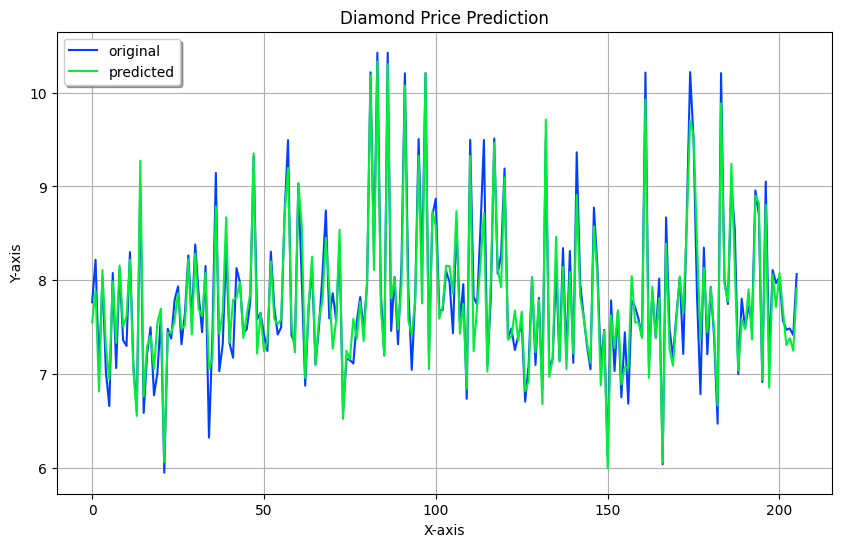

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, n_estimators=125, max_features='auto', max_depth=20, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(X_train_tune, y_train)

# Validation
y_val_pred = tune_model.predict(X_val_tune)
grid_1_rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
grid_1_r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(X_test_tune)
end_time = time.time()
current_run_time = round(end_time - start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_small_grid.append(current_run_time)

# Evaluate the performance on the test set
grid_1_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
grid_1_r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_small_grid.append(grid_1_r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {grid_1_rmse_test}")
print(f"-> R2 on testing: {grid_1_r2_test}")

# Plot result of prediction after using Grid 1 GridSearchCV
x_ax = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Diamond Price Prediction")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

### Second Parameters Grid with GridSearchCV

In [ ]:
grid_param_grid_2 = {
  'bootstrap': [True, False],
  'max_depth': [40, 50, 60, 70, 80],
  'max_features': ['auto', 'sqrt', 6, 8, 10],
  'n_estimators': [150, 200, 250, 300, 350]
 }

In [ ]:
scaler = MinMaxScaler()
X_train_tune = X_train.copy()
X_train_tune[numeric_cols] = scaler.fit_transform(X_train_tune[numeric_cols])

X_val_tune = X_val.copy()
X_val_tune[numeric_cols] = scaler.transform(X_val_tune[numeric_cols])

X_test_tune = X_test.copy()
X_test_tune[numeric_cols] = scaler.transform(X_test_tune[numeric_cols])

In [ ]:
# forest_model = RandomForestRegressor(random_state=42)

# # Initialize grid search 2
# grid_search_2 = GridSearchCV(estimator=forest_model, param_grid=grid_param_grid_2, cv=3, scoring='r2', return_train_score=True, n_jobs = -1)

# # Fitting the grid 2 to train data
# grid_search_2.fit(X_train_tune, y_train)
# grid_search_2.best_params_

{'bootstrap': True, 'max_depth': 40, 'max_features': 8, 'n_estimators': 150}

Training & Validating on RandomForestRegressor(max_depth=40, max_features=8, n_estimators=150,
                      random_state=42) model
- Time of fitting RandomForestRegressor(max_depth=40, max_features=8, n_estimators=150,
                      random_state=42) model: 0.423 (s)
Testing RandomForestRegressor(max_depth=40, max_features=8, n_estimators=150,
                      random_state=42) model
-> RMSE on testing: 0.22748693936627296
-> R2 on testing: 0.9284556969872626


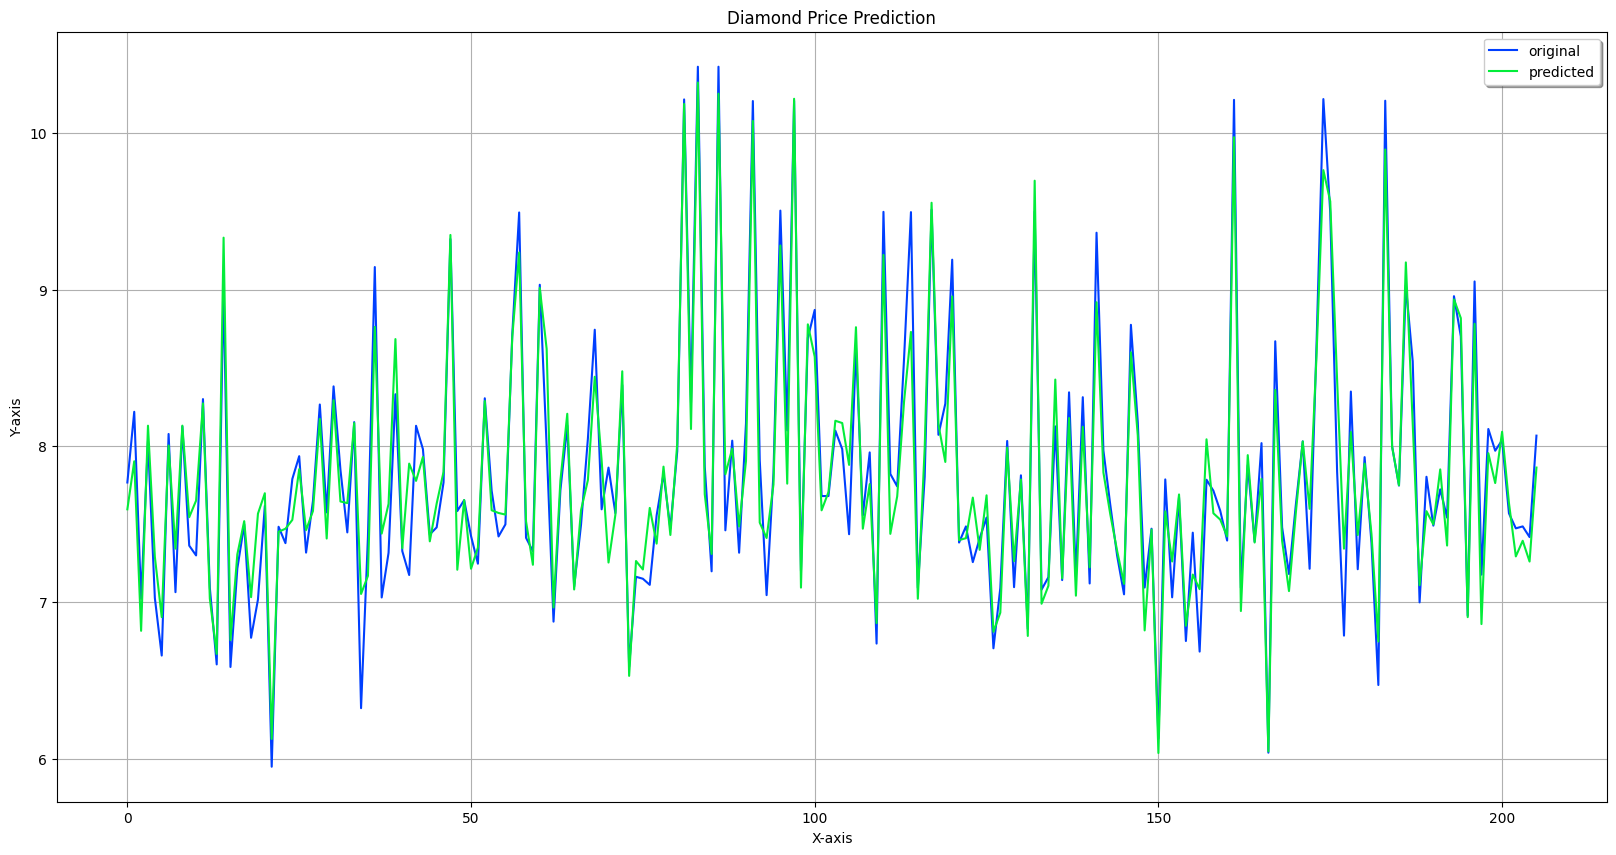

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, n_estimators=150, max_features=8, max_depth=40, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(X_train_tune, y_train)

# Validation
y_val_pred = tune_model.predict(X_val_tune)
grid_2_rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
grid_2_r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(X_test_tune)
end_time = time.time()
current_run_time = round(end_time- start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_small_grid.append(current_run_time)

# Evaluate the performance on the test set
grid_2_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
grid_2_r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_small_grid.append(grid_2_r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {grid_2_rmse_test}")
print(f"-> R2 on testing: {grid_2_r2_test}")

# Plot result of prediction after using Grid 2 GridSearchCV
x_ax = range(len(y_test))
plt.figure(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Diamond Price Prediction")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [ ]:
# # Intialize the list using the base and the improved RandomForest Regression models
grid_improved_reg_models_small = ['RandomForestRegression', 'RandomForestRegression_GridSearch_1', 'RandomForestRegression_GridSearch_2']

# # Compare the testing data R2 Score of the base and the improved RandomForest Regression models by using GridSearchCV
grid_improved_model_r2_compare_small = pd.DataFrame({'Models' : grid_improved_reg_models_small, 'Improved_Testing_R2_Score' : improved_test_r2_score_small_grid})
grid_improved_model_r2_compare_small.sort_values(by='Improved_Testing_R2_Score', ascending=False)

,Models,Improved_Testing_R2_Score
0,RandomForestRegression,0.929098
1,RandomForestRegression_GridSearch_1,0.928558
2,RandomForestRegression_GridSearch_2,0.928456


[Text(0, 0, 'RandomForestRegression'),
 Text(1, 0, 'RandomForestRegression_GridSearch_1'),
 Text(2, 0, 'RandomForestRegression_GridSearch_2')]

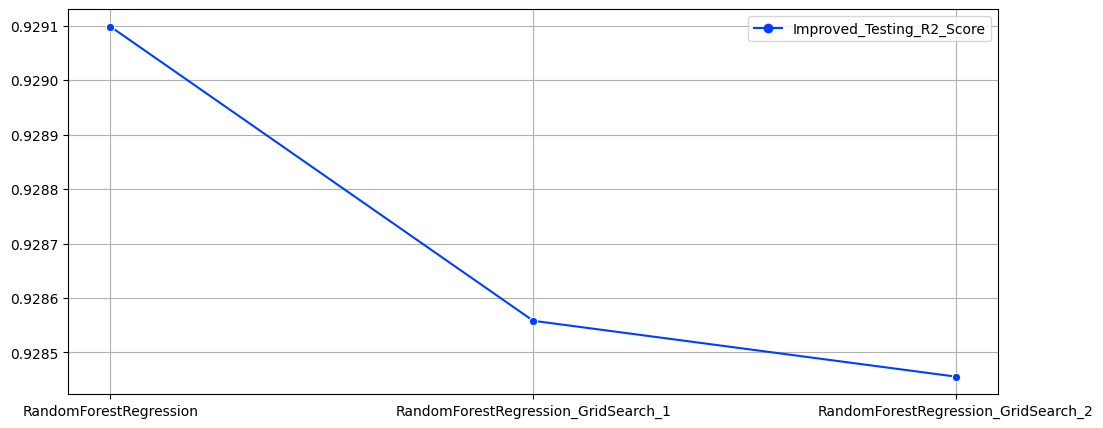

In [ ]:
# Visualize the testing data R2 Scores of the base and the improved RandomForest Regression models by using GridSearchCV
plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-bright')
plt.grid(True)
ax = sns.lineplot(data=[grid_improved_model_r2_compare_small['Improved_Testing_R2_Score']], dashes=False, markers=True)
ax.set_xticks(range(len(grid_improved_model_r2_compare_small['Models'])))
ax.set_xticklabels(grid_improved_model_r2_compare_small['Models'])

### Third Parameters Grid with GridSearchCV

In [ ]:
grid_param_grid_3 = {
  'bootstrap': [True, False],
  'max_depth': [5, 10, 15, 20, 25, 30, 35],
  'max_features': ['auto', 'sqrt', 2, 4, 6, 8, 10],
  'n_estimators': [150, 175, 200, 225]
}

In [ ]:
scaler = MinMaxScaler()
X_train_tune = X_train.copy()
X_train_tune[numeric_cols] = scaler.fit_transform(X_train_tune[numeric_cols])

X_val_tune = X_val.copy()
X_val_tune[numeric_cols] = scaler.transform(X_val_tune[numeric_cols])

X_test_tune = X_test.copy()
X_test_tune[numeric_cols] = scaler.transform(X_test_tune[numeric_cols])

In [ ]:
# forest_model = RandomForestRegressor(random_state=42)

# # Initialize grid search 3
# grid_search_3 = GridSearchCV(estimator=forest_model, param_grid=grid_param_grid_3, cv=3, scoring='r2', return_train_score=True, n_jobs = -1)

# # Fitting the grid 3 to train data
# grid_search_3.fit(X_train_tune, y_train)
# grid_search_3.best_params_

{'bootstrap': True, 'max_depth': 15, 'max_features': 10, 'n_estimators': 200}

Training & Validating on RandomForestRegressor(max_depth=15, max_features=10, n_estimators=200,
                      random_state=42) model
- Time of fitting RandomForestRegressor(max_depth=15, max_features=10, n_estimators=200,
                      random_state=42) model: 0.571 (s)
Testing RandomForestRegressor(max_depth=15, max_features=10, n_estimators=200,
                      random_state=42) model
-> RMSE on testing: 0.22424886778420744
-> R2 on testing: 0.9304779387892895


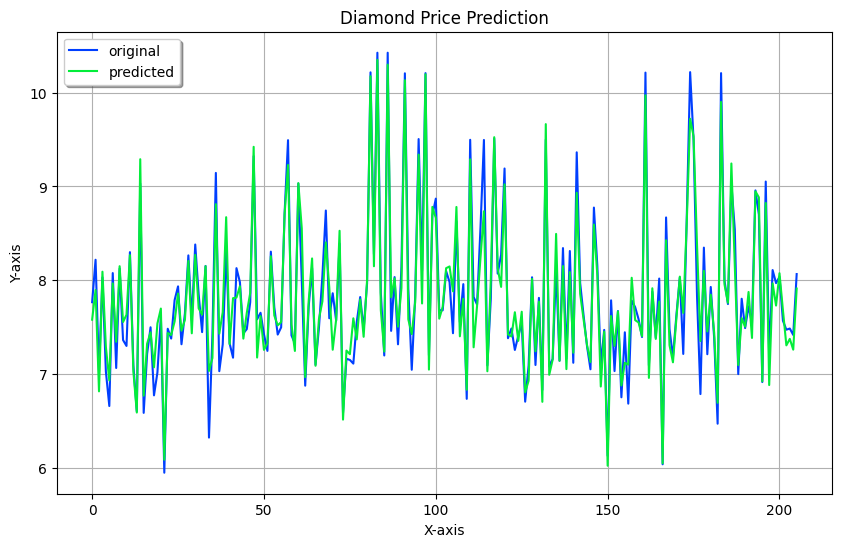

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, n_estimators=200, max_features=10, max_depth=15, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(X_train_tune, y_train)

# Validation
y_val_pred = tune_model.predict(X_val_tune)
grid_3_rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
grid_3_r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(X_test_tune)
end_time = time.time()
current_run_time = round(end_time- start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_small_grid.append(current_run_time)

# Evaluate the performance on the test set
grid_3_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
grid_3_r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_small_grid.append(grid_3_r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {grid_3_rmse_test}")
print(f"-> R2 on testing: {grid_3_r2_test}")

# Plot result of prediction after using Grid 2 GridSearchCV
x_ax = range(len(y_test))
plt.figure(figsize=(10, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Diamond Price Prediction")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [ ]:
# grid_improved_reg_models_small.append('RandomForestRegression_GridSearch_3')
# grid_improved_model_r2_compare_small = pd.DataFrame({'Models' : grid_improved_reg_models_small, 'Improved_Testing_R2_Score' : improved_test_r2_score_small_grid})
grid_improved_model_r2_compare_small.sort_values(by='Improved_Testing_R2_Score', ascending=False)

,Models,Improved_Testing_R2_Score
3,RandomForestRegression_GridSearch_3,0.930478
0,RandomForestRegression,0.929098
1,RandomForestRegression_GridSearch_1,0.928558
2,RandomForestRegression_GridSearch_2,0.928456


In [ ]:
# temp_lr_df = ['1.000', 'Random Forest Regression (GridSearchCV)', run_time_small_grid[-1], grid_improved_model_r2_compare_small.iloc[3, 1]*100]
# final_result.append(temp_lr_df)
final_result

[['1.000', 'Linear Regression', 0.04, 88.09653361986646],
 ['1.000', 'Random Forest Regression Base', 0.04, 92.90980375625129],
 ['1,000',
  'Random Forest Regression (RandomizedSearchCV)',
  4.524,
  92.80346099576703],
 ['1,000',
  'Random Forest Regression (GridSearchCV)',
  0.571,
  93.04779387892896]]

[Text(0, 0, 'RandomForestRegression'),
 Text(1, 0, 'RandomForestRegression_GridSearch_1'),
 Text(2, 0, 'RandomForestRegression_GridSearch_2'),
 Text(5, 0, 'RandomForestRegression_GridSearch_3')]

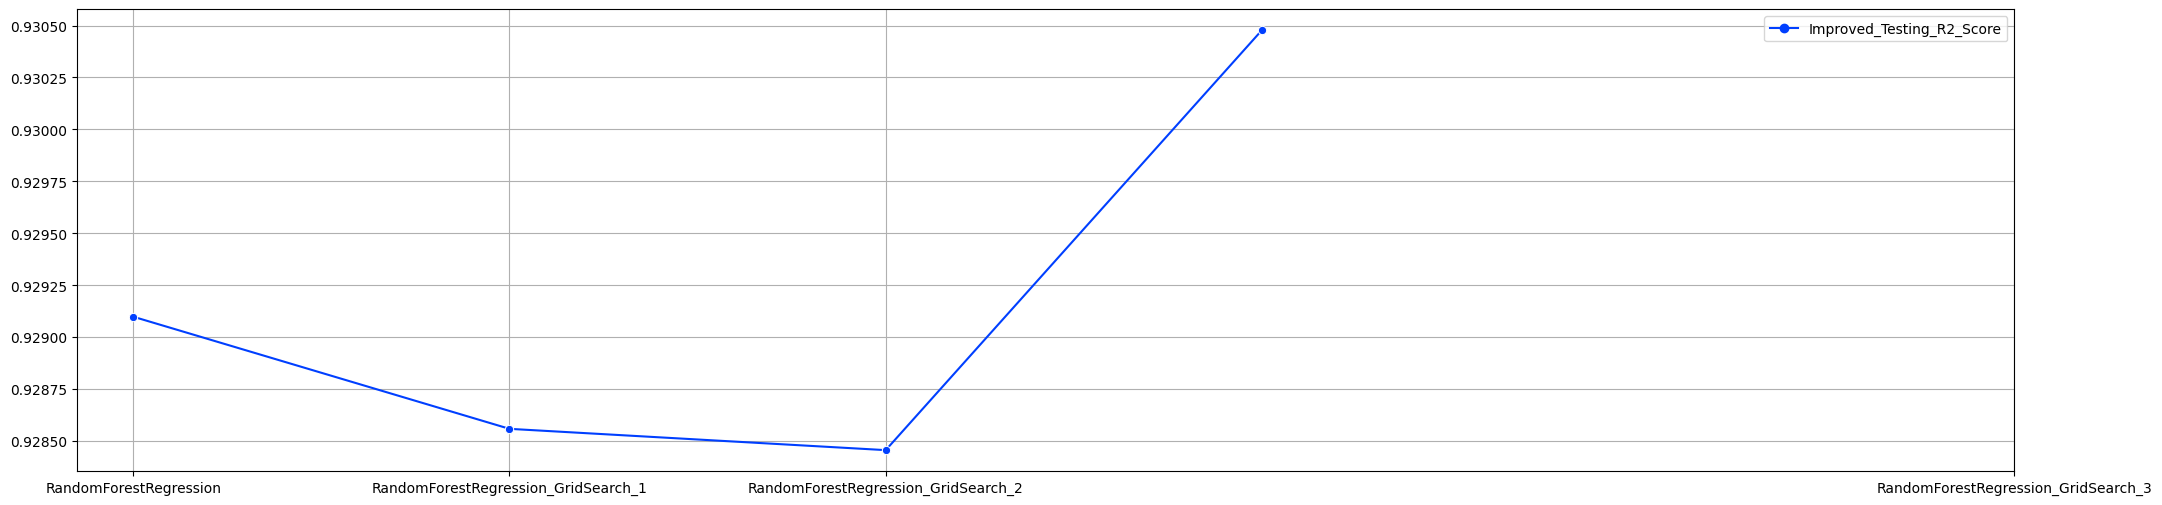

In [ ]:
# Visualize the testing data R2 Scores of the base and the improved RandomForest Regression models by using GridSearchCV
plt.figure(figsize=(25, 6))
plt.style.use('seaborn-v0_8-bright')
plt.grid(True)
ax = sns.lineplot(data=[grid_improved_model_r2_compare_small['Improved_Testing_R2_Score']], dashes=False, markers=True)
ax.set_xticks([0, 1, 2, 5])
ax.set_xticklabels(grid_improved_model_r2_compare_small['Models'])

In [ ]:
grid_improved_model_r2_compare_small.iloc[-1]

Models                       RandomForestRegression_GridSearch_3
Improved_Testing_R2_Score                               0.930478
Name: 5, dtype: object

### **Nhận xét sự cải thiện hiệu quả mô hình khi sử dụng GridSearchCV**
Sự cải thiện của model thu được từ việc hiệu chỉnh các Hyperparamter của RandomForest Regressor như: n_estimator, bootstrap, max_features, max_depth... được tìm kiếm với ***GridSearchCV*** kết hợp cùng cross-validation (3-folds). Kết quả thu được như sau:
- R2 Score trên test data theo thứ tự giảm dần như sau:

> 1. RandomForest Regression using Third Grid Search
> 2. RandomForest Regression base
> 3. RandomForest Regression using First Grid Search
> 4. RandomForest Regression using Seccond Grid Search

- The Base RandomForest Regression model có hiệu quả mô hình cao nhất rơi vào khoảng ***93.04%*** (R2_Score) khoảng ***0.13%*** so với Base RandomForest Regression với ***92.91%***.
- Trong khi đó, RandomForest Regression sử dụng First Grid Search và First Random Search có hiệu quả mô hình lần lượt là ***92.86%*** và ***92.85%***, giảm một chút khoảng ***0.05%*** và ***0.06%*** so với Base RandomForest Regression.

##***Nhận xét chung đối với 1,000 samples data***
- Thử nghiệm với cả 2 mô hình là ***Linear Regression*** và ***RandomForest Regression*** thì ta có thể thấy ***RandomForest Regression*** có ***R2 Score*** cao hơn (***92.91%*** so với ***88.10%***).
- Thử nghiệm tìm kiếm siêu tham số (***Hyperparameter***) mô hình ***RandomForest Regression*** với 2 công cụ ***RandomizedSearchCV và GridSearchCV*** cho kết quả như sau:

> + ***RandomizedSearchCV***: độ chính xác mô hình giảm so với không sử dụng (***92.91% -> 92.80% -> 92.24%***).
> + ***GridSearchCV***: độ chính xác mô hình tăng lên một chút so với không sử dụng (***92,91% -> 93.05%***) khoảng ***0.14%***.

> Theo tìm hiểu thì ***RandomizedSearchCV*** sẽ hiệu quả hơn khi tìm kiếm siêu tham số trên dữ liệu có kích thước lớn, còn ***GridSearchCV*** sẽ hiệu quả hơn khi tìm kiếm trên dữ liệu có kích thước nhỏ.

#***10,000 samples data***

##**Load Data for 10,000 samples data**

In [20]:
path = 'data_'
big_data = pd.read_csv("data_big_clean.csv")

In [21]:
big_data.head()

,Shape,Carat,Color,Clarity,Cut,Fluorescence,Polish,Symmetry,Length,Width,Depth,Log_Price
0,0,0.53,6,1,0,1,1,2,4.42,4.39,3.24,7.215975
1,0,0.44,5,5,0,1,0,3,4.27,4.10,3.00,7.536897
2,0,0.59,0,2,0,1,0,2,4.73,4.69,3.38,7.695303
3,0,0.46,1,3,0,1,2,3,4.37,4.26,3.08,7.730614
4,0,0.43,1,4,0,1,2,3,4.25,4.16,2.94,7.297768


##**Prepare data for building model**

### Split data to train/ validation/ test by 60/20/20

In [22]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, f_regression, RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import time

<Axes: >

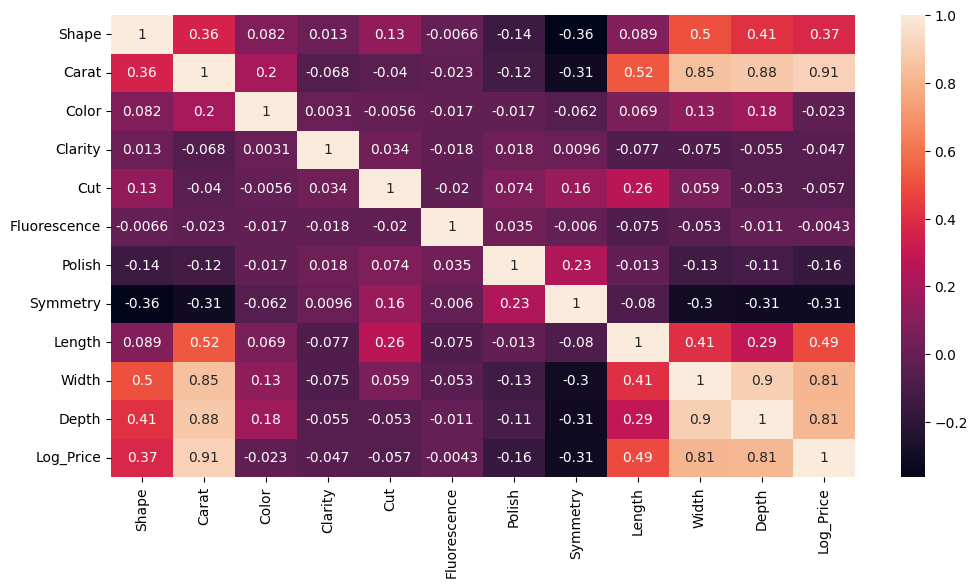

In [23]:
df_diamond = big_data.copy()
correlation_matrix = df_diamond.corr()
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True)

Từ heatmap ở trên, ta có thể nhận xét như sau:
- Length, Width, Depth có tương quan khá mạnh với giá (Log_Price)
- Carat có tương quan mạnh nhất đối với giá (Log_Price) - 0.89
- Polish, Symmetry có tương quan yếu nhất
- Từ đây ta có thể thấy Carat tương quan tốt nhất với giá. Ta sẽ dùng feature này cho Stratified Sampling




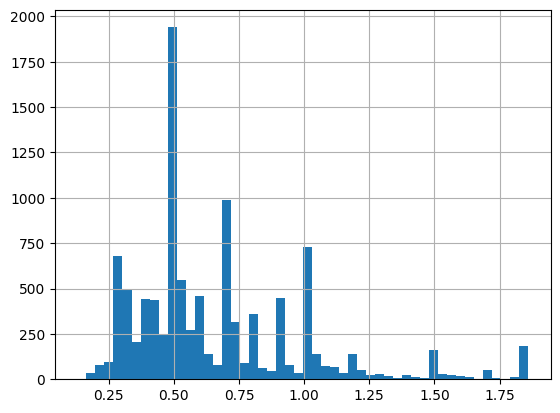

In [24]:
df_diamond["Carat"].hist(bins = 50)
plt.show()

Ta thấy phần lớn rơi vào khoảng từ 0.3 đến 1.5 carat. Ta có thể chia chúng làm 5 loại, những viên có carat lớn hơn loại 5 thì xếp vào loại 5.

In [25]:
# Divide diamond carats by 0.32 to limit the number of each carat categories
df_diamond['Carat_Category'] = np.ceil(df_diamond['Carat']/0.31)

# Merge categories > 5 in 5
df_diamond["Carat_Category"].where(df_diamond["Carat_Category"] < 5, 5.0, inplace = True)

In [26]:
df_diamond["Carat_Category"].value_counts()

2.0    4865
3.0    2481
4.0    1336
1.0    1120
5.0     611
Name: Carat_Category, dtype: int64

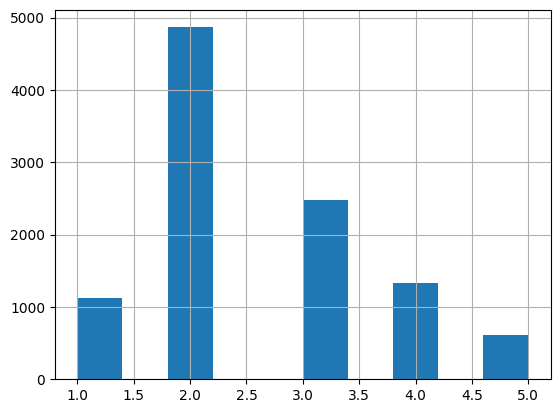

In [27]:
df_diamond["Carat_Category"].hist()
plt.show()

Phân bố các nhóm carat khá ổn sau khi được chia thành 5 loại
- Bây giờ, ta sẽ chia data bằng Stratified Sampling dựa trên carat categories (Function StratifiedShuffleSplit of Scikit-Learn's)
- Ta sẽ chia data thành 3 phần 60/20/20 tương ứng với Train/Validation/Test

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

# Run the split. Creates one split and shares 20% of the dataset for the test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Separate the stratified train set and the test set
for train_index, test_index in split.split(df_diamond, df_diamond["Carat_Category"]):
  stratified_train_set = df_diamond.iloc[train_index]
  stratified_test_set = df_diamond.iloc[test_index]

# Perform another split on the train set to create a train/validation set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

# Separate the stratified train set and the validation set
for train_index, val_index in split.split(stratified_train_set, stratified_train_set["Carat_Category"]):
  stratified_val_set = stratified_train_set.iloc[val_index]
  stratified_train_set = stratified_train_set.iloc[train_index]

print(f"Train data size: {len(stratified_train_set)}")
print(f"Validation data size: {len(stratified_val_set)}")
print(f"Test data size: {len(stratified_test_set)}")

Train data size: 6247
Validation data size: 2083
Test data size: 2083


In [29]:
# Train set
X_train = stratified_train_set.drop(['Log_Price', 'Carat_Category'], axis=1)
y_train = stratified_train_set['Log_Price']
# Validation set
X_val = stratified_val_set.drop(['Log_Price', 'Carat_Category'], axis=1)
y_val = stratified_val_set['Log_Price']
# Test set
X_test = stratified_test_set.drop(['Log_Price', 'Carat_Category'], axis=1)
y_test = stratified_test_set['Log_Price']

### Categorical and Numerical features

In [30]:
numeric_cols = ['Carat',
                'Length',
                'Width',
                'Depth']
object_cols = [col for col in X_train.columns if col not in numeric_cols]
print("Categorical variables:", object_cols)
print("Numeric variables:", numeric_cols)

Categorical variables: ['Shape', 'Color', 'Clarity', 'Cut', 'Fluorescence', 'Polish', 'Symmetry']
Numeric variables: ['Carat', 'Length', 'Width', 'Depth']


In [31]:
scaler = MinMaxScaler()
X_train_copy = X_train.copy()
X_train_copy[numeric_cols] = scaler.fit_transform(X_train_copy[numeric_cols])

X_val_copy = X_val.copy()
X_val_copy[numeric_cols] = scaler.transform(X_val_copy[numeric_cols])

X_test_copy = X_test.copy()
X_test_copy[numeric_cols] = scaler.transform(X_test_copy[numeric_cols])

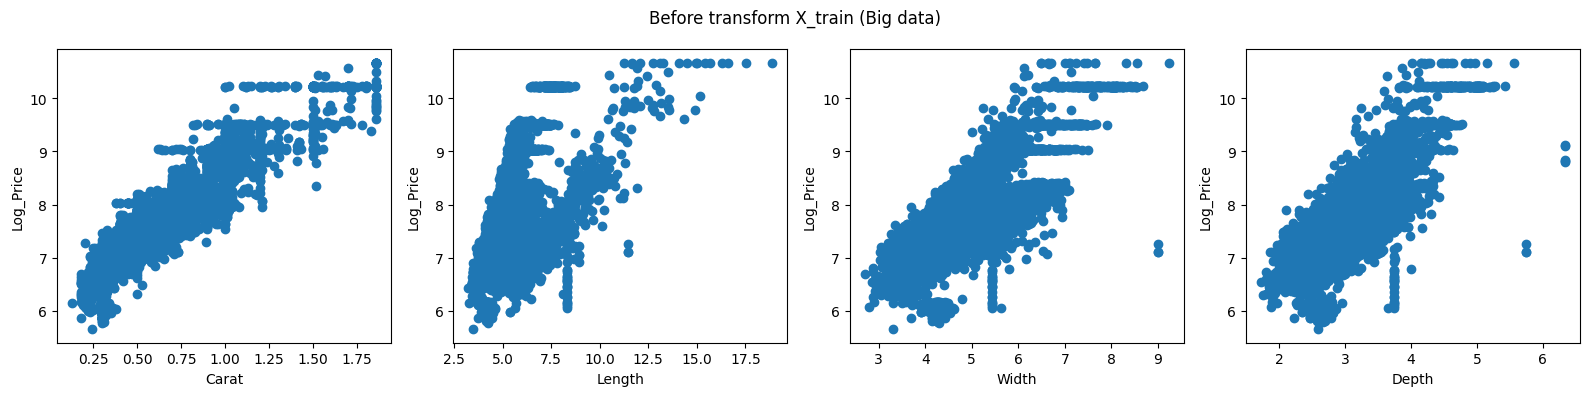

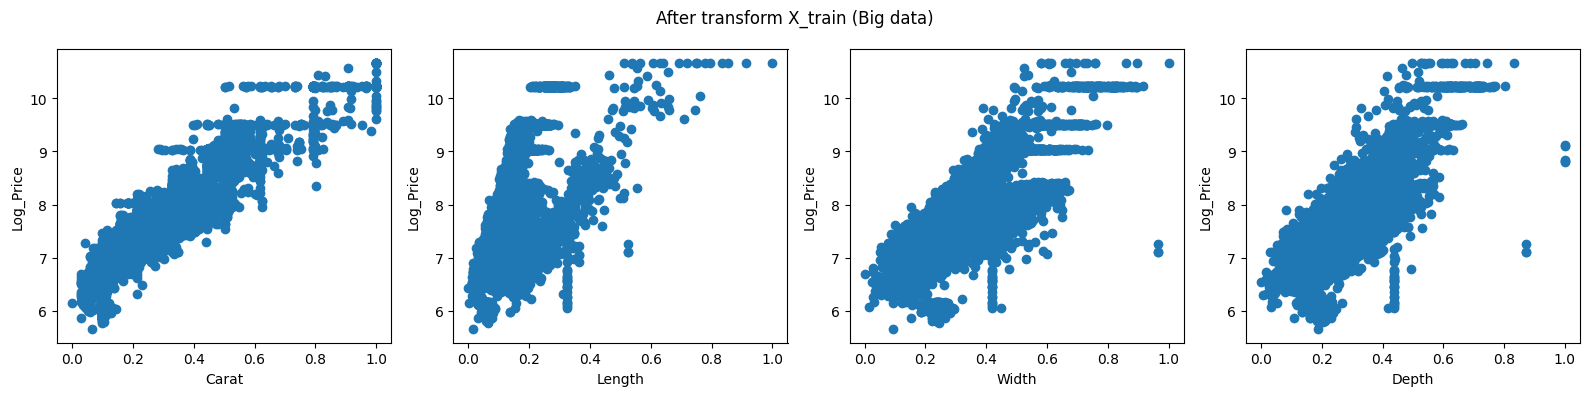

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, column in enumerate(numeric_cols):
    axs[i].scatter(X_train[column], y_train, label=column)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Log_Price')

fig.suptitle('Before transform X_train (Big data)')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, column in enumerate(numeric_cols):
    axs[i].scatter(X_train_copy[column], y_train, label=column)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Log_Price')

fig.suptitle('After transform X_train (Big data)')
plt.tight_layout()
plt.show()

##**Model Building**
- Linear Regression
- Random Forest Regression


--- Training & Validating on Linear Regression model | MinMaxScaler---
- Time of fitting Linear Regression model: 0.013 (s)
  + RMSE on training: 0.3126950092012186
  + R2 on training: 0.8755453327676593
------------ Testing Linear Regression model | MinMaxScaler-----------
-> RMSE on testing: 0.3136070593650239
-> R2 on testing: 0.8762683510589288

--- Training & Validating on Random Forest Regression model | MinMaxScaler---
- Time of fitting Random Forest Regression model: 2.399 (s)
  + RMSE on training: 0.1753073020267567
  + R2 on training: 0.9608826612875282
------------ Testing Random Forest Regression model | MinMaxScaler-----------
-> RMSE on testing: 0.1782974732193012
-> R2 on testing: 0.9600055694698639

--- Training & Validating on Linear Regression model | StandardScaler---
- Time of fitting Linear Regression model: 0.011 (s)
  + RMSE on training: 0.31269500920121857
  + R2 on training: 0.8755453327676594
------------ Testing Linear Regression model | StandardScaler-------

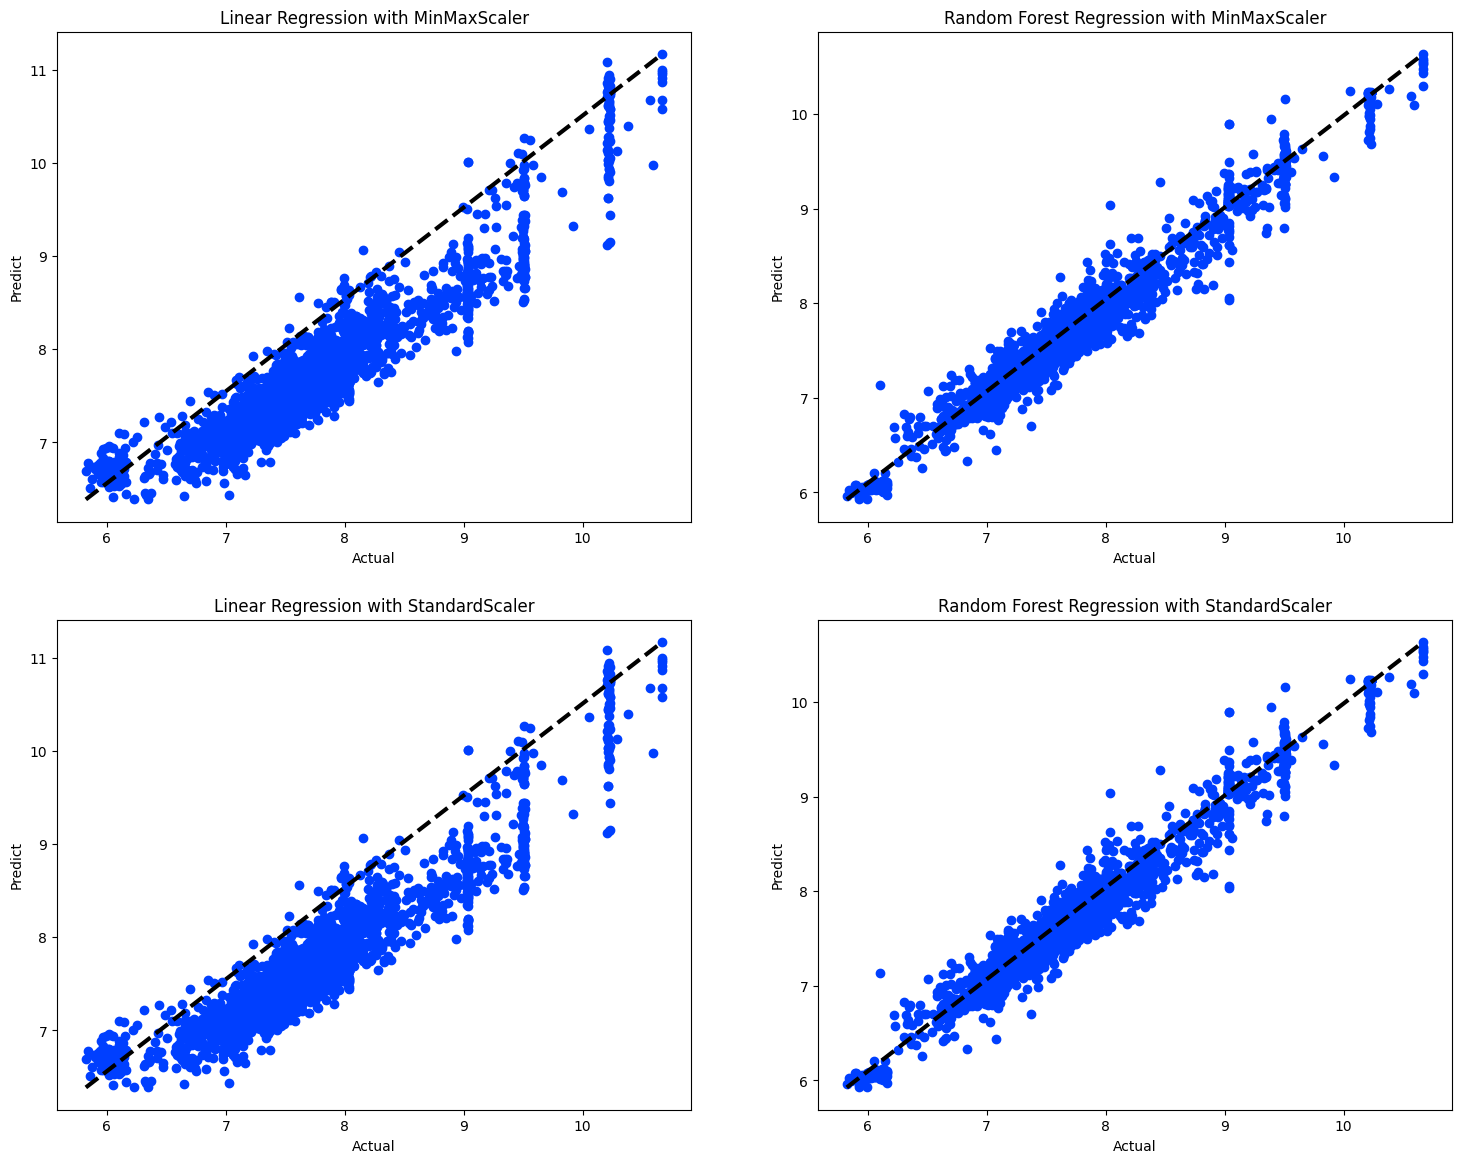

In [ ]:
scaler_list = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

regressor_list = {
  'Linear Regression': LinearRegression(),
  'Random Forest Regression': RandomForestRegressor(random_state=42)
}

regression_name = []
result_r2_compare_big = []

figure, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
i = 0

for scaler_name, scaler in scaler_list.items():
  j = 0
  res_r2_scaler = []
  for reg_name, regressor in regressor_list.items():
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()
    X_test_copy = X_test.copy()
    X_train_copy[numeric_cols] = scaler.fit_transform(X_train_copy[numeric_cols])
    X_val_copy[numeric_cols] = scaler.transform(X_val_copy[numeric_cols])
    X_test_copy[numeric_cols] = scaler.transform(X_test_copy[numeric_cols])

    regression_name.append(reg_name)
    # Define the pipeline
    pipeline = Pipeline(steps=[(reg_name, regressor)])
    
    # Fit pipeline to train data
    print(f"--- Training & Validating on {reg_name} model | {scaler_name}---")
    start_train = time.time()
    pipeline.fit(X_train_copy, y_train)
    
    y_val_pred = pipeline.predict(X_val_copy)
    rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
    r2_train = r2_score(y_val, y_val_pred)

    end_train = time.time()
    train_time = round(end_train - start_train, 3)
    print(f"- Time of fitting {reg_name} model: {train_time} (s)")
    print(f"  + RMSE on training: {rmse_train}")
    print(f"  + R2 on training: {r2_train}")

    # Predict on the test data
    y_test_pred = pipeline.predict(X_test_copy)
    # Evaluate the performance on the test set
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"------------ Testing {reg_name} model | {scaler_name}-----------")
    print(f"-> RMSE on testing: {rmse_test}")
    print(f"-> R2 on testing: {r2_test}")
    print('='*70,'\n')
    res_r2_scaler.append([reg_name, scaler_name, r2_train, r2_test, train_time])

    # Plot predict result
    axs[i, j].scatter(y_test, y_test_pred)
    axs[i, j].plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'k--', lw=3)

    axs[i, j].set_xlabel('Actual')
    axs[i, j].set_ylabel('Predict')
    axs[i, j].set_title(f'{reg_name} with {scaler_name}')

    j += 1
  i += 1
  result_r2_compare_big.append(res_r2_scaler)

In [ ]:
result_r2_compare_df_big = pd.DataFrame(result_r2_compare_big[0], columns=['Regressor', 'Scaler', 'R2 Training Score', 'R2 Testing Score', 'Training Time'])
result_r2_compare_df_big.sort_values(by='R2 Testing Score', ascending=False)

,Regressor,Scaler,R2 Training Score,R2 Testing Score,Training Time
1,Random Forest Regression,MinMaxScaler,0.960883,0.960006,2.399
0,Linear Regression,MinMaxScaler,0.875545,0.876268,0.013


In [ ]:
# temp_linear_df = ['10.000', result_r2_compare_df_big.iloc[0, 0], result_r2_compare_df_big.iloc[0, 4], result_r2_compare_df_big.iloc[0, 3] * 100]
# temp_rf_df = ['10.000', f"{result_r2_compare_df_big.iloc[1, 0]} Base", result_r2_compare_df_big.iloc[1, 4], result_r2_compare_df_big.iloc[1, 3] * 100]
# final_result.append(temp_linear_df)
# final_result.append(temp_rf_df)
final_result

[['1.000', 'Linear Regression', 0.04, 88.09653361986646],
 ['1.000', 'Random Forest Regression Base', 0.04, 92.90980375625129],
 ['1,000',
  'Random Forest Regression (RandomizedSearchCV)',
  4.524,
  92.80346099576703],
 ['1,000',
  'Random Forest Regression (GridSearchCV)',
  0.571,
  93.04779387892896],
 ['10,000', 'Linear Regression', 0.013, 87.62683510589288],
 ['10,000', 'Random Forest Regression Base', 2.399, 96.00055694698639]]

[Text(0, 0, 'Linear Regression'), Text(1, 0, 'Random Forest Regression')]

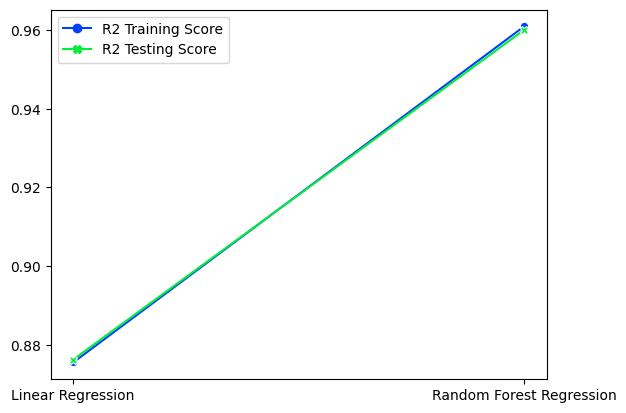

In [ ]:
# Visualize the training and the testing R2 Scores of 2 models
ax = sns.lineplot(data=[result_r2_compare_df_big['R2 Training Score'], result_r2_compare_df_big['R2 Testing Score']], dashes=False, markers=True)
ax.set_xticks(range(len(result_r2_compare_df_big['Regressor'])))
ax.set_xticklabels(result_r2_compare_df_big['Regressor'])

### **Nhận xét**
Ta sẽ sử dụng 2 metrics là ***RMSE*** và ***R2 Score*** để đánh giá hiệu suất mô hình.
- **Giá trị RMSE càng nhỏ** thì mô hình càng hiệu quả
- **Giá trị R2 Score càng lớn** thì mô hình càng hiệu quả

Nhưng ta sẽ sử dụng ***R2 Score*** để đánh giá hiệu quả mô hình vì nó tương tự như ***Accuracy*** để trực quan hơn ***RMSE***.


*   Sắp xếp R2 Score đối với training và validating data như sau:


> 1. RandomForest Regression
> 2. Linear Regression


*   Sắp xếp R2 Score đối với testing data như sau:


> 1. RandomForest Regression
> 2. Linear Regression

Ta có thể thấy rằng việc sử dụng RandomForest Regression (***96.00%***) mang lại hiệu quả tốt hơn Linear Regression (***87.62%***) về mặt Training & Validating và cả mặt Testing.



## **Hyperparameter Tuning Using RandomizedSearchCV and GridSearchCV**


*   Các hyperparameter quan trọng với RandomForest Regressor:


> 1. n_estimators: numbe of trees in the forest
> 2. max_features: maximum number of features considered for splitting a node
> 3. max_depth: depth of trees in the forest





In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf_base_r2_big = max(result_r2_compare_df_big.sort_values(by='R2 Testing Score', ascending=False)['R2 Testing Score'])

# List of improvement R2 Score using Grid Search with Cross Validation
improved_test_r2_score_big = [rf_base_r2_big]

# List to track the run time of improvement models
run_time_big = []

### First Parameters Grid with RandomizedSearchCV

In [ ]:
random_param_grid_1 = {
  'bootstrap': [True, False],
  'max_depth': [10, 20, 30, 40, 50],
  'max_features': ['auto', 'sqrt'],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [100, 200, 400, 600, 800, 1000]
 }

In [ ]:
scaler = MinMaxScaler()
X_train_tune = X_train.copy()
X_train_tune[numeric_cols] = scaler.fit_transform(X_train_tune[numeric_cols])

X_val_tune = X_val.copy()
X_val_tune[numeric_cols] = scaler.transform(X_val_tune[numeric_cols])

X_test_tune = X_test.copy()
X_test_tune[numeric_cols] = scaler.transform(X_test_tune[numeric_cols])

In [ ]:
# forest_model = RandomForestRegressor()

# # Using RandomizedSearchCV to tune hyperparameters
# rf_random = RandomizedSearchCV(estimator=forest_model, param_distributions=random_param_grid_1, n_iter=30, cv=5, random_state=42, n_jobs=-1)

# # Fit the random search model
# rf_random.fit(X_train_tune, y_train)
# rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

Training & Validating on RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1000, random_state=42) model
- Time of fitting RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1000, random_state=42) model: 17.275 (s)
Testing RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1000, random_state=42) model
-> RMSE on testing: 0.17746868219843892
-> R2 on testing: 0.9603765224019707


Text(0.5, 1.0, 'RandomForest Regression using Params Grid 1')

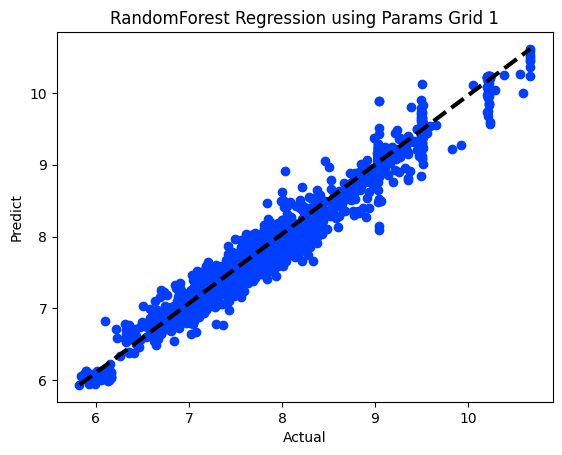

In [ ]:
rf_model = RandomForestRegressor(bootstrap=False, n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(X_train_tune, y_train)

# Validation
y_val_pred = tune_model.predict(X_val_tune)
grid_1_rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
grid_1_r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(X_test_tune)
end_time = time.time()
current_run_time = round(end_time - start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_big.append(current_run_time)

# Evaluate the performance on the test set
grid_1_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
grid_1_r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_big.append(grid_1_r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {grid_1_rmse_test}")
print(f"-> R2 on testing: {grid_1_r2_test}")

# Plot result of prediction after using Grid 1 RandomizedSearchCV
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'k--', lw=3)

plt.xlabel('Actual')
plt.ylabel('Predict')
plt.title('RandomForest Regression using Params Grid 1')

### Second Parameters Grid with RandomizedSearchCV

In [ ]:
random_param_grid_2 = {
  'bootstrap': [True, False],
  'max_depth': [60, 70, 80, 90, 100, None],
  'max_features': ['auto', 'sqrt', 6, 8, 10],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [150, 250, 1200, 1400, 1600, 1800, 2000]
 }

In [ ]:
scaler = MinMaxScaler()
X_train_tune = X_train.copy()
X_train_tune[numeric_cols] = scaler.fit_transform(X_train_tune[numeric_cols])

X_val_tune = X_val.copy()
X_val_tune[numeric_cols] = scaler.transform(X_val_tune[numeric_cols])

X_test_tune = X_test.copy()
X_test_tune[numeric_cols] = scaler.transform(X_test_tune[numeric_cols])

In [ ]:
# forest_model = RandomForestRegressor()

# # Using RandomizedSearchCV to tune hyperparameters
# rf_random = RandomizedSearchCV(estimator=forest_model, param_distributions=random_param_grid_2, n_iter=30, cv=5, random_state=42, n_jobs=-1)

# # Fit the random search model
# rf_random.fit(X_train_tune, y_train)
# rf_random.best_params_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': 100,
 'bootstrap': True}

Training & Validating on RandomForestRegressor(max_depth=100, max_features=10, n_estimators=1400,
                      random_state=42) model
- Time of fitting RandomForestRegressor(max_depth=100, max_features=10, n_estimators=1400,
                      random_state=42) model: 34.698 (s)
Testing RandomForestRegressor(max_depth=100, max_features=10, n_estimators=1400,
                      random_state=42) model
-> RMSE on testing: 0.17584440954252717
-> R2 on testing: 0.961098506785092


Text(0.5, 1.0, 'RandomForest Regression using Params Grid 2')

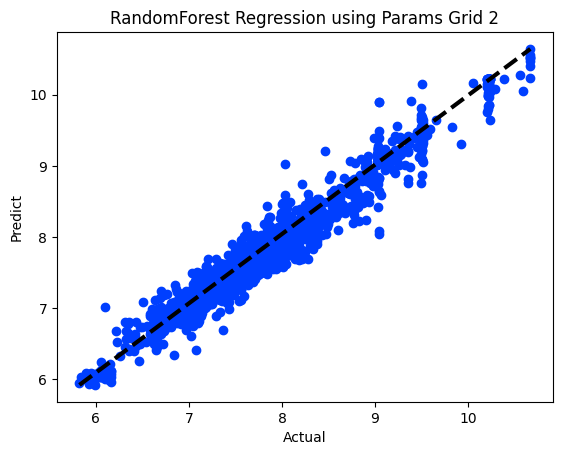

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=10, max_depth=100, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(X_train_tune, y_train)

# Validation
y_val_pred = tune_model.predict(X_val_tune)
grid_2_rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
grid_2_r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(X_test_tune)
end_time = time.time()
current_run_time = round(end_time- start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_big.append(current_run_time)

# Evaluate the performance on the test set
grid_2_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
grid_2_r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_big.append(grid_2_r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {grid_2_rmse_test}")
print(f"-> R2 on testing: {grid_2_r2_test}")

# Plot result of prediction after using Grid 2 RandomizedSearchCV
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'k--', lw=3)

plt.xlabel('Actual')
plt.ylabel('Predict')
plt.title('RandomForest Regression using Params Grid 2')

In [ ]:
# Intialize the list using the base and the improved RandomForest Regression models
improved_reg_models_big = ['RandomForestRegression', 'RandomForestRegression_RandomSearch_1', 'RandomForestRegression_RandomSearch_2']

# Compare the testing data R2 Score of the base and the improved RandomForest Regression models by using RandomizedSearchCV
improved_model_r2_compare_big = pd.DataFrame({'Models' : improved_reg_models_big, 'Improved_Testing_R2_Score' : improved_test_r2_score_big})
improved_model_r2_compare_big.sort_values(by='Improved_Testing_R2_Score', ascending=False)

,Models,Improved_Testing_R2_Score
2,RandomForestRegression_RandomSearch_2,0.961099
1,RandomForestRegression_RandomSearch_1,0.960377
0,RandomForestRegression,0.960006


In [ ]:
# temp_lr_df = ['10.000', 'Random Forest Regression (RandomizedSearchCV)', run_time_big[1], improved_model_r2_compare_big.iloc[2, 1]*100]
# final_result.append(temp_lr_df)
final_result

[['1.000', 'Linear Regression', 0.04, 88.09653361986646],
 ['1.000', 'Random Forest Regression Base', 0.04, 92.90980375625129],
 ['1,000',
  'Random Forest Regression (RandomizedSearchCV)',
  4.524,
  92.80346099576703],
 ['1,000',
  'Random Forest Regression (GridSearchCV)',
  0.571,
  93.04779387892896],
 ['10,000', 'Linear Regression', 0.013, 87.62683510589288],
 ['10,000', 'Random Forest Regression Base', 2.399, 96.00055694698639],
 ['10.000',
  'Random Forest Regression (RandomizedSearchCV)',
  34.698,
  96.1098506785092]]

[Text(0, 0, 'RandomForestRegression'),
 Text(1, 0, 'RandomForestRegression_RandomSearch_1'),
 Text(2, 0, 'RandomForestRegression_RandomSearch_2')]

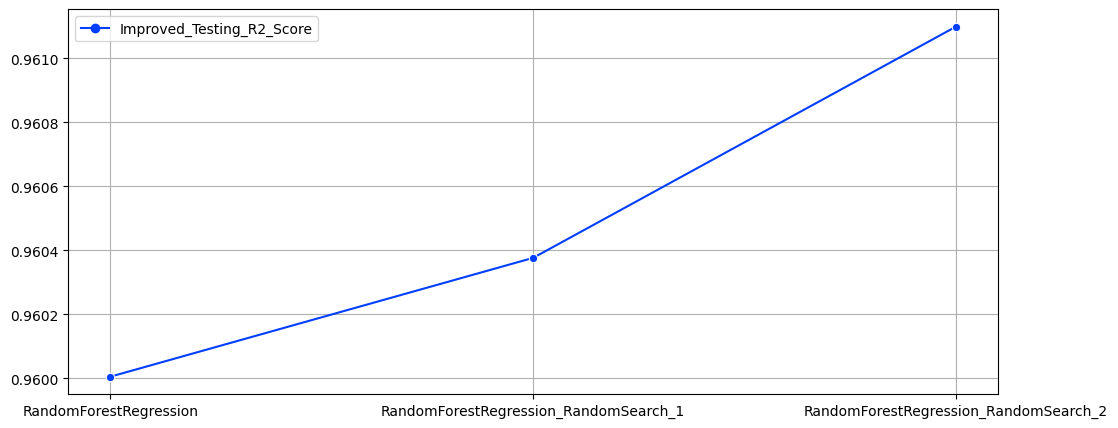

In [ ]:
# Visualize the testing data R2 Scores of the base and the improved RandomForest Regression models by using RandomizedSearchCV
plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-bright')
plt.grid(True)
ax = sns.lineplot(data=[improved_model_r2_compare_big['Improved_Testing_R2_Score']], dashes=False, markers=True)
ax.set_xticks(range(len(improved_model_r2_compare_big['Models'])))
ax.set_xticklabels(improved_model_r2_compare_big['Models'])

### **Nhận xét sự cải thiện hiệu quả mô hình**
Sự cải thiện của model thu được từ việc hiệu chỉnh các Hyperparamter của ***RandomForest Regressor*** như: n_estimator, bootstrap, max_features, max_depth... được tìm kiếm với ***RandomizedSearchCV*** kết hợp cùng cross-validation (5-folds). Kết quả thu được như sau:
- R2 Score trên test data theo thứ tự giảm dần như sau:

> 1. RandomForest Regression using Second Random Search
> 2. RandomForest Regression using First Random Search
> 3. RandomForest Regression base

- Base RandomForest Regression model có hiệu quả mô hình rơi vào khoảng ***96.00%*** (R2_Score).
- Trong khi đó, RandomForest Regression sử dụng Second Random Search và First Random Search có hiệu quả mô hình lần lượt là ***96.11%*** và ***96.04%***, tăng lên một chút khoảng ***0.11%*** và ***0.04%*** so với Base RandomForest Regression.

In [ ]:
# View numerical feature importances
importances = list(tune_model.feature_importances_)

# Get the columns of the training data
features = X_train_tune.columns
     
# View the most important features
importances = [round(importance, 2) for importance in importances]
df_feature_imp = pd.DataFrame({'Feature' : features, 'Importance' : importances})
df_feature_imp.sort_values(by='Importance', ascending=False, inplace=True)
df_feature_imp

,Feature,Importance
1,Carat,0.78
10,Depth,0.06
0,Shape,0.05
2,Color,0.03
3,Clarity,0.02
8,Length,0.02
9,Width,0.02
4,Cut,0.00
5,Fluorescence,0.00
6,Polish,0.00


<Axes: xlabel='Importance', ylabel='Feature'>

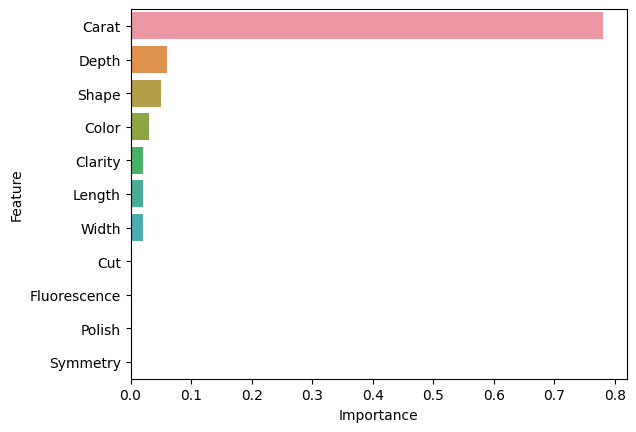

In [ ]:
# Visualize those importance features
sns.barplot(x="Importance", y="Feature", data=df_feature_imp)

#### **Nhận xét về sự quan trọng của các đặc trưng (features) của kim cương đối với việc dự đoán giá**
Từ đồ thị trên ta có thể rút ra 1 số nhận xét sau:
- ***Carat*** là đặc trưng quan trọng nhất và đóng góp lớn nhất cho việc dự đoán giá kim cương với mức quan trọng ***0.78***.
- Sau ***Carat*** là những đặc trưng như ***Depth*** (chiều sâu), ***Shape*** (hình dáng) với mức quan trọng lần lượt là 0.06, 0.05.
- Sau ***Shape*** là ***Color*** (màu sắc), ***Length*** (chiều dài), ***Clarity*** (độ trong suốt), ***Width*** (chiều rộng) với mức quan trọng lần lượt là 0.03, 0.02, 0.02, 0.02.
- ***Cut***, ***Fluorescence***, ***Polish***, ***Symmetry*** là 4 đặc trưng kém quan trọng nhất hầu như không tác động nhiều đến giá kim cương.

In [ ]:
# Get the names of 7 most important features
important_feature_columns = df_feature_imp['Feature'][0:7]
important_feature_columns

1       Carat
10      Depth
0       Shape
2       Color
3     Clarity
8      Length
9       Width
Name: Feature, dtype: object

In [ ]:
# Create the new train, validation and test data contain just 7 most important features
important_X_train = X_train[important_feature_columns]
important_X_val = X_val[important_feature_columns]
important_X_test = X_test[important_feature_columns]

Training & Validating on RandomForestRegressor(max_depth=100, max_features=10, n_estimators=1400,
                      random_state=42) model
- Time of fitting RandomForestRegressor(max_depth=100, max_features=10, n_estimators=1400,
                      random_state=42) model: 30.38 (s)
Testing RandomForestRegressor(max_depth=100, max_features=10, n_estimators=1400,
                      random_state=42) model
-> RMSE on testing: 0.18076499130770105
-> R2 on testing: 0.9588909169740726


Text(0.5, 1.0, 'RandomForest Regression using 7 most important features')

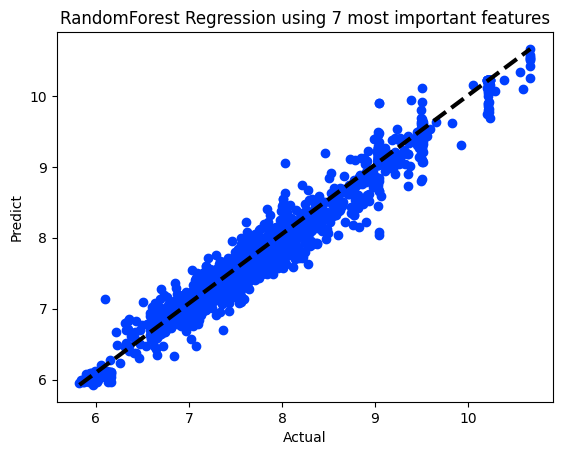

In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=10, max_depth=100, random_state=42)

print(f"Training & Validating on {rf_model} model")
start_time  = time.time()
tune_model = rf_model.fit(important_X_train, y_train)

# Validation
y_val_pred = tune_model.predict(important_X_val)
rmse_train = mean_squared_error(y_val, y_val_pred, squared=False)
r2_train = r2_score(y_val, y_val_pred)

# Predict on the test data
y_test_pred = tune_model.predict(important_X_test)
end_time = time.time()
current_run_time = round(end_time - start_time, 3)
print(f"- Time of fitting {rf_model} model: {current_run_time} (s)")
run_time_big.append(current_run_time)

# Evaluate the performance on the test set
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)
improved_test_r2_score_big.append(r2_test)

print(f"Testing {rf_model} model")
print(f"-> RMSE on testing: {rmse_test}")
print(f"-> R2 on testing: {r2_test}")

# Plot result of prediction after using 7 most important features
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(), y_test_pred.max()], 'k--', lw=3)

plt.xlabel('Actual')
plt.ylabel('Predict')
plt.title('RandomForest Regression using 7 most important features')

In [ ]:
improved_reg_models_big.append('RandomForestRegression_ImportantFeatures')
improved_model_r2_compare_big = pd.DataFrame({'Models' : improved_reg_models_big, 'Improved_Testing_R2_Score' : improved_test_r2_score_big})
improved_model_r2_compare_big.sort_values(by='Improved_Testing_R2_Score', ascending=False)

,Models,Improved_Testing_R2_Score
2,RandomForestRegression_RandomSearch_2,0.961099
1,RandomForestRegression_RandomSearch_1,0.960377
0,RandomForestRegression,0.960006
3,RandomForestRegression_ImportantFeatures,0.958891


In [ ]:
# temp_lr_df = ['10.000', 'Random Forest Regression (Important Features)', run_time_big[-1], improved_model_r2_compare_big.iloc[3, 1]*100]
# final_result.append(temp_lr_df)
final_result

[['1.000', 'Linear Regression', 0.04, 88.09653361986646],
 ['1.000', 'Random Forest Regression Base', 0.04, 92.90980375625129],
 ['1,000',
  'Random Forest Regression (RandomizedSearchCV)',
  4.524,
  92.80346099576703],
 ['1,000',
  'Random Forest Regression (GridSearchCV)',
  0.571,
  93.04779387892896],
 ['10,000', 'Linear Regression', 0.013, 87.62683510589288],
 ['10,000', 'Random Forest Regression Base', 2.399, 96.00055694698639],
 ['10.000',
  'Random Forest Regression (RandomizedSearchCV)',
  34.698,
  96.1098506785092],
 ['10.000',
  'Random Forest Regression (Important Features)',
  30.38,
  95.88909169740725]]

[Text(0, 0, 'RandomForestRegression'),
 Text(1, 0, 'RandomForestRegression_RandomSearch_1'),
 Text(2, 0, 'RandomForestRegression_RandomSearch_2'),
 Text(3, 0, 'RandomForestRegression_ImportantFeatures')]

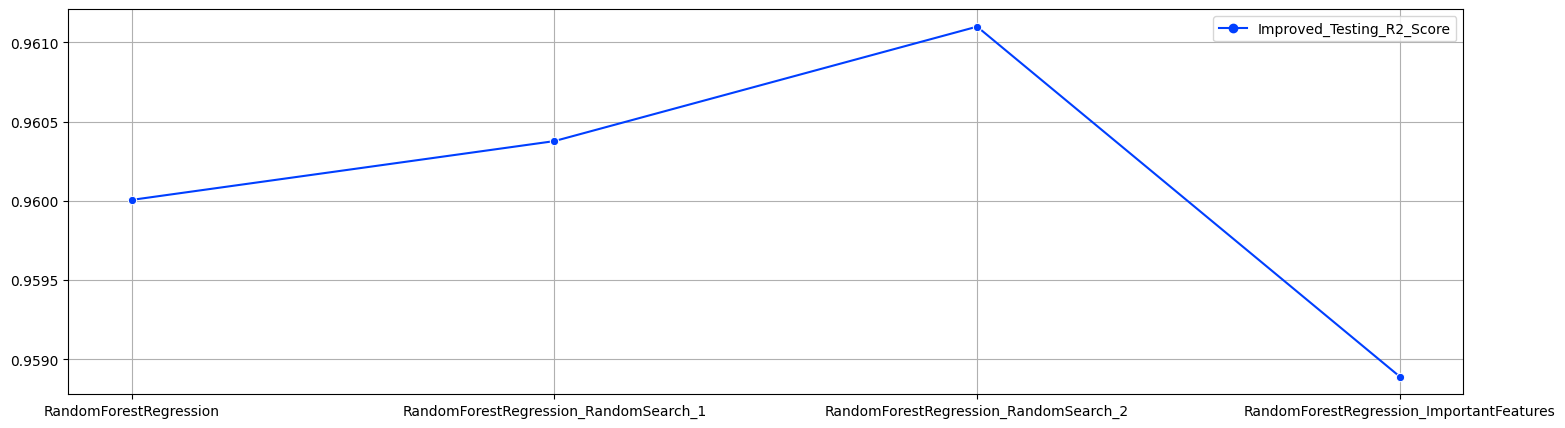

In [ ]:
# Visualize the testing data R2 Scores of the base, the improve, and the most important feature RandomForest Models
plt.figure(figsize=(18, 5))
plt.style.use('seaborn-v0_8-bright')
plt.grid(True)
ax = sns.lineplot(data=[improved_model_r2_compare_big['Improved_Testing_R2_Score']], dashes=False, markers=True)
ax.set_xticks(range(len(improved_model_r2_compare_big['Models'])))
ax.set_xticklabels(improved_model_r2_compare_big['Models'])

In [ ]:
all_features_r2_score = round(improved_test_r2_score_big[-2], 4) * 100
most_imp_features_r2_score = round(improved_test_r2_score_big[-1], 4) * 100

all_features_run_time = round(run_time_big[-2], 4)
most_imp_features_run_time = round(run_time_big[-1], 4)

r2_score_decrease = round(((all_features_r2_score - most_imp_features_r2_score) / all_features_r2_score) * 100, 4)
run_time_decrease = round(((all_features_run_time - most_imp_features_run_time) / all_features_run_time) * 100, 4)

compare_table = pd.DataFrame({'Features': ['All Features', '7 Most Important Features', 'Decrease (%)'],
                               'R2 Score(%)': [all_features_r2_score, most_imp_features_r2_score, r2_score_decrease],
                               'Train time(s)': [all_features_run_time, most_imp_features_run_time, run_time_decrease]})
compare_table

,Features,R2 Score(%),Train time(s)
0,All Features,96.1100,34.6980
1,7 Most Important Features,95.8900,30.3800
2,Decrease (%),0.2289,12.4445


##**Nhận xét chung đối với 10,000 samples data**
- Mô hình sử dụng ***RandomForest Regression*** có ***R2 Score*** cao hơn khoảng ***8.35%*** so với ***Linear Regression*** (***96.00%*** so với ***87.62%***)
- ***RandomForest Regression*** khi được hiệu chỉnh bằng các ***Hyperparameter*** được tìm kiếm từ ***RandomizedSearchCV*** thì độ chính xác mô hình được tăng lên khoảng ***0.11%*** (***96.00% -> 96.11%***)
- Khi ta lựa chọn 7 đặc trưng quan trọng nhất ra để sử dụng dự đoán giá thì:


> + Độ chính xác giảm từ ***96.11%*** xuống còn ***95.89%*** (giảm khoảng ***0.23%***)
> + Thời gian train mô hình cũng sẽ giảm khá nhiều từ ***34.70(s)*** còn ***30.38(s)*** (giảm khoảng ***12.45%***)|


- Ta có thể thấy mặc dù có một số đặc trưng không đóng góp mức quan trọng nhiều nhưng nó vẫn có thể mang lại hiệu quả trong việc dự đoán giá nhờ kết hợp cùng các đặc trưng khác quan trọng hơn. Từ đó cho ta hiệu quả cao hơn.

#***Kết luận trên 2 datasets (1,000 và 10,000 samples)***

In [ ]:
result_columns = ['Data size (samples)', 'Models', 'Train time (s)', 'R2 Score (%)']
final_result_df = pd.DataFrame(final_result, columns=result_columns)

In [ ]:
final_result_df

,Data size (samples),Models,Train time (s),R2 Score (%)
0,1.000,Linear Regression,0.040,88.096534
1,1.000,Random Forest Regression Base,0.040,92.909804
2,1.000,Random Forest Regression (RandomizedSearchCV),4.524,92.803461
3,1.000,Random Forest Regression (GridSearchCV),0.571,93.047794
4,10.000,Linear Regression,0.013,87.626835
5,10.000,Random Forest Regression Base,2.399,96.000557
6,10.000,Random Forest Regression (RandomizedSearchCV),34.698,96.109851
7,10.000,Random Forest Regression (Important Features),30.380,95.889092


## **Theo bảng trên ta có thể nhận xét:**
+ ***Linear Regression*** khi sử dụng ở **10.000 mẫu** cho độ chính xác (***R2 Score***) **thấp hơn** khoảng ***0.47%*** chính nó khi sử dụng ở **1.000 mẫu** cụ thể là ***87.63%*** so với ***88.10%***.
+ ***RandomForest Regression*** khi sử dụng ở **10.000 mẫu** cho độ chính xác (***R2 Score***) **cao hơn** khoảng ***3.09%*** chính nó khi sử dụng ở **1.000 mẫu** cụ thể là ***96.00%*** so với ***92.91%***.
+ Sau khi hiệu chỉnh bằng siêu tham số thì độ chính xác **tăng lên** nhưng không đáng kể khoảng ***0.11%*** (***96.00% -> 96.11%***)
+ Khi sử dụng bộ 7 đặc trưng quan trọng nhất để dự đoán thì độ chính xác **giảm xuống** còn ***95.89%*** nhưng thời gian train cũng giảm theo từ ***34.698(s) -> 30.380(s)***.

+ ***Khi sử dụng RandomizedSearchCV và GridSearchCV cho RandomForest Regression:***

> + Tốn nhiều thời gian hơn so với mô hình Base nhưng không phải lúc nào cũng cho kết quả tốt hơn.
> + ***Kích thước dữ liệu càng lớn*** thì thời gian train **càng lâu** và khi sử dụng ***RandomizedSearchCV*** để tìm bộ siêu tham số thì sẽ tốn thời gian hơn rất nhiều lần.
> + Ở tập ***dữ liệu 1.000 mẫu*** thì sử dụng ***GridSearchCV*** sẽ tìm bộ siêu tham số nhanh hơn và hiệu quả mô hình ứng với bộ siêu tham số đó cũng tốt hơn so với sử dụng ***RandomizedSearchCV***. Thời gian giảm từ ***4.524(s) -> 0.571(s)*** và độ chính xác tăng từ ***92.80% -> 93.05%***.
> + Ở tập ***dữ liệu 10.000 mẫu*** thì sử dụng ***RandomizedSearchCV*** sẽ có lợi hơn bởi nó tìm kiếm tốt trên dữ liệu lớn so với ***GridSearchCV***
>   + Sau khi hiệu chỉnh bằng siêu tham số thì độ chính xác **tăng lên** nhưng không đáng kể khoảng ***0.11%*** (***96.00% -> 96.11%***)
>   + Thời gian tăng lên rất nhiều từ ***2.399(s) -> 34.698(s)***

## ***Tóm lại***: **Mô hình cho dự đoán về giá kim cương khá chính xác với độ chính xác lên đến khoảng 96.1% với thời gian dự đoán cũng khá tốt khoảng 34.7 (s)**.